In [1]:
# import packages
import glob
from pathlib import Path
import os
import numpy as np
from datetime import datetime
from datetime import timedelta
import pandas as pd
import calendar
import geopandas as gpd
import cartopy
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import xarray as xr
from pathos.threading import ThreadPool as Pool
from scipy.optimize import least_squares
import sklearn
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import random
import cartopy.crs as ccrs
from scipy.stats import gaussian_kde
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy import stats

In [2]:
# define your script working directory
# work_dir=Path("/mnt/u/LSM root zone/global_sr/")
# work_dir=Path('/tudelft.net/staff-umbrella/LSM root zone/global_sr')
work_dir=Path("/scratch/fransjevanoors/global_sr/")
# define your data directory
data_dir=Path(f'{work_dir}/data')

out_dir=Path(f'{work_dir}/output')

In [3]:
#colors
a = 255/255
b = 220/255
c = 201/255
d = 133/255
e = 85/255
f = 70/255
g = 46/255

c1 = (e,0,0)
c2 = (c,0,0)
c3 = (a,g,0)
c4 = (a,d,0)
c5 = (a,b,0)
c6 = (a,a,f)
c7 = (f,a,a)
c8 = (0,b,a)
c9 = (0,d,a)
c10 = (0,g,a)
c11 = (0,0,c)
c12 = (0,0,e)

colors=[c12,c11,c10,c9,c8,c7,c6,c5,c4,c3,c2,c1]
cm = ListedColormap(colors)

### 1. map selected catchments

/tmp/ipykernel_3055/840378724.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sh['centroid'] = sh.centroid
/tmp/ipykernel_3055/840378724.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sh.centroid.plot(markersize=0.7,ax=ax)


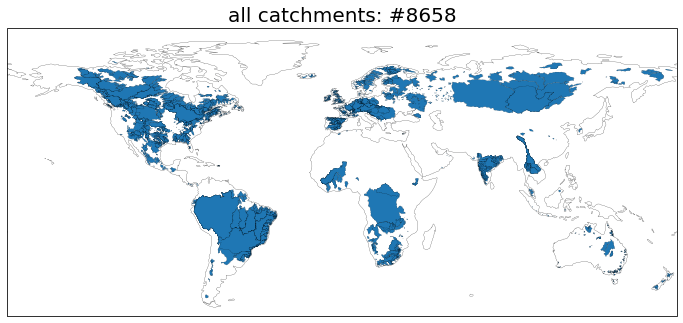

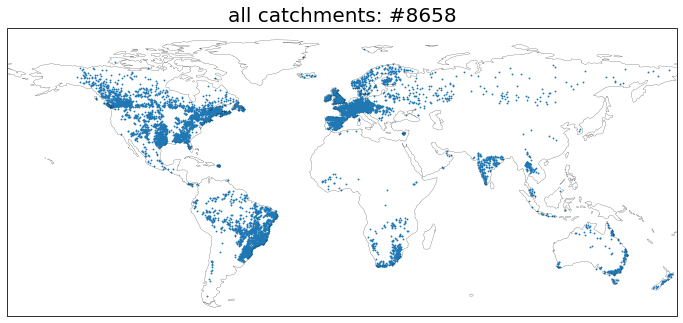

In [3]:
# map all catchments
sh = gpd.read_file(f'{out_dir}/geo_catchments.shp')
sh.index = sh.catch_id
sh['centroid'] = sh.centroid

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.2)
sh.plot(edgecolor='black',linewidth=0.1,ax=ax)
ax.set_title(f'all catchments: #{len(sh)}',size=20)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{out_dir}/figures/catchment_overview/map_allcatchments_shapes.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.2)
sh.centroid.plot(markersize=0.7,ax=ax)
ax.set_title(f'all catchments: #{len(sh)}',size=20)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{out_dir}/figures/catchment_overview/map_allcatchments_points.jpg',bbox_inches='tight',dpi=300)

/tmp/ipykernel_3055/2912706931.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sh['centroid'] = sh.centroid
/tmp/ipykernel_3055/2912706931.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sh.centroid.plot(markersize=0.7,ax=ax)


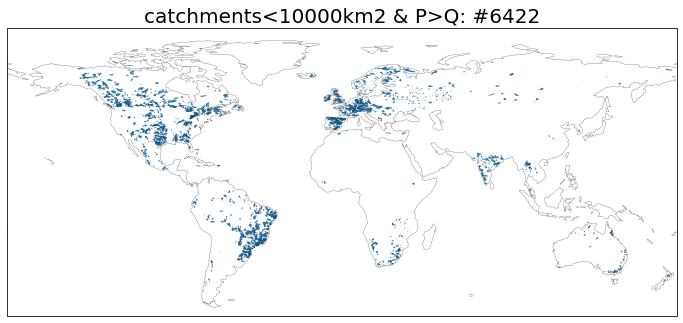

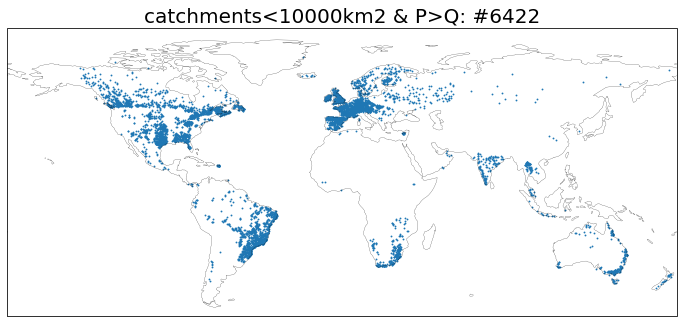

In [4]:
# map selected catchments based on area and wb
sh = gpd.read_file(f'{out_dir}/geo_catchments_sel_area_wb.shp')
sh.index = sh.catch_id
sh['centroid'] = sh.centroid

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.2)
sh.plot(edgecolor='black',linewidth=0.05,ax=ax)
ax.set_title(f'catchments<10000km2 & P>Q: #{len(sh)}',size=20)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{out_dir}/figures/catchment_overview/map_selcatchments_shapes.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.2)
sh.centroid.plot(markersize=0.7,ax=ax)
ax.set_title(f'catchments<10000km2 & P>Q: #{len(sh)}',size=20)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{out_dir}/figures/catchment_overview/map_selcatchments_points.jpg',bbox_inches='tight',dpi=300)

### 2. plot catchments in budyko

In [5]:
# load selected catchment characteristics based on area and wb
c = pd.read_csv(f'{out_dir}/catchment_characteristics_sel_area_wb.csv',index_col=0)
c.head()

p_mean   ep_mean    q_mean     t_mean        ai      si_p  \
102101A  5.013324  3.821485  2.451285  26.111414  1.311879  0.845662   
104001A  3.615239  3.384188  1.232168  25.894186  1.068274  1.013597   
105101A  4.120194  3.548841  0.837701  24.468281  1.160997  0.838043   
105102A  3.051206  3.247410  0.742289  24.834575  0.939581  0.945253   
105105A  5.280687  3.848386  1.194697  24.624683  1.372182  0.805871   

            si_ep  phi         tc        ntc     nonveg    area  
102101A  0.166897    2  23.077881  64.030838  12.891281   648.4  
104001A  0.176452    3  17.910576  67.989027  14.100397   473.7  
105101A  0.168695    2  19.812427  64.472516  15.715056  2308.6  
105102A  0.169238    4  14.801930  68.073281  17.124789  1322.0  
105105A  0.181118    0  22.074308  62.859330  15.066361   296.1

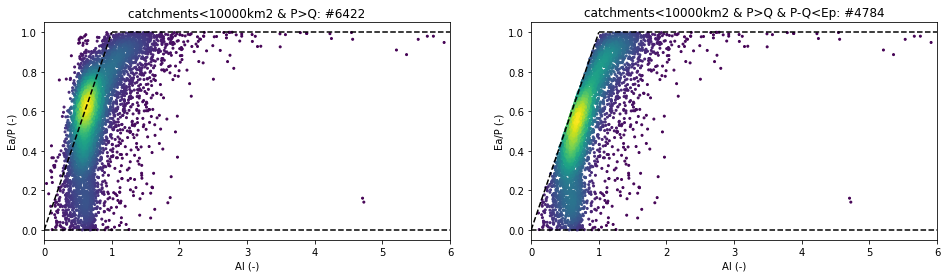

In [6]:
# plot catchments in budyko
ep = c.ep_mean
p = c.p_mean
q = c.q_mean
x = ep/p
y = (p-q)/p
x = x.dropna() # a few points with nan for AI
y = y[x.index]

# calculate point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.scatter(x,y,c=z,s=4)
ax.plot([0,1],[0,1], '--k')
ax.plot([1,12],[1,1], '--k')
ax.plot([0,12],[0,0], '--k')
ax.set_xlabel('AI (-)')
ax.set_ylabel('Ea/P (-)')
ax.set_xlim(0,6)
ax.set_ylim(-0.05,1.05)
ax.set_title(f'catchments<10000km2 & P>Q: #{len(c)}')

# plot catchments in budyko - only when Ea<Ep
cs = c[c.ep_mean>(c.p_mean-c.q_mean)]
ep = cs.ep_mean
p = cs.p_mean
q = cs.q_mean
x = ep/p
y = (p-q)/p
x = x.dropna() # a few points with nan for AI
y = y[x.index]

# calculate point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(122)
ax.scatter(x,y,c=z,s=4)
ax.plot([0,1],[0,1], '--k')
ax.plot([1,12],[1,1], '--k')
ax.plot([0,12],[0,0], '--k')
ax.set_xlabel('AI (-)')
ax.set_ylabel('Ea/P (-)')
ax.set_xlim(0,6)
ax.set_ylim(-0.05,1.05)
ax.set_title(f'catchments<10000km2 & P>Q & P-Q<Ep: #{len(cs)}')
fig.savefig(f'{out_dir}/figures/catchment_overview/budyko_selcatchments.jpg',bbox_inches='tight',dpi=300)


### 3. make histograms of catchment characteristics

In [40]:
c = pd.read_csv(f'{out_dir}/catchment_characteristics_sel_area_wb.csv',index_col=0)

In [41]:
c

p_mean   ep_mean    q_mean     t_mean        ai       hai  \
za_0000167  2.731415  2.225398  0.926851  14.217723  1.227383  0.840285   
de_0000129  3.163824  1.889784  2.214790   8.689071  1.674172  0.474841   
es_0000787  0.988730  2.018325  0.083651  16.170287  0.489876  2.638748   
br_0001831  4.406135  2.940346  1.433599  24.315706  1.498509  0.890740   
es_0001076  1.649784  1.793561  0.267195  11.431009  0.919837  1.127141   
...              ...       ...       ...        ...       ...       ...   
fr_0000086  2.960251  1.917064  0.833332   9.474569  1.544159  0.528857   
ca_0001025  2.447737  1.933218  1.049551   4.543701  1.266146  0.497999   
br_0001145  2.744817  2.879167  0.098244  24.941000  0.953337  1.466824   
138113A     2.672268  2.906840  0.696340  19.930897  0.919303  1.203693   
us_0005811  4.117093  2.838132  3.295804  18.818386  1.450635  0.738008   

            tdiff_max  tdiff_mean  idu_mean  idu_max  ...  el_min  \
za_0000167  12.429797   10.844969         4       44  ...     0.0   
de_0000129  25.799998   21.369999         3       19  ...     0.0   
es_0000787  20.125003   18.418750        10       48  ...     0.0   
br_0001831   6.845615    5.000735         7       68  ...     0.0   
es_0001076  20.941724   18.550423         4       30  ...     0.0   
...               ...         ...       ...      ...  ...     ...   
fr_0000086  22.599999   19.033333         4       26  ...     0.0   
ca_0001025  38.306040   31.570967         3       13  ...     0.0   
br_0001145   6.179158    5.019867         3       28  ...     0.0   
138113A     13.918751   11.685617         5       31  ...    82.0   
us_0005811  24.588438   20.306005         4       19  ...     0.0   

                 el_max       drd   slp_mean        cla        snd        slt  \
za_0000167  3349.000000  0.586669   3.652460  17.603860  22.948590  13.341310   
de_0000129  1375.000000  0.598772   1.502280   7.075282  19.963570  18.350640   
es_0000787  1402.000000  0.128505   1.035570   7.579044  11.245660  10.911320   
br_0001831  1031.000000  0.510362   0.904059  19.213730  25.228540   8.795617   
es_0001076  1668.000000  0.507645   1.985210  10.763680  17.326550  18.181140   
...                 ...       ...        ...        ...        ...        ...   
fr_0000086  1462.000000  0.555368   3.067230  10.971780  16.547550  17.526400   
ca_0001025   562.000000  0.600461   0.900791   6.976063  31.175160  23.594320   
br_0001145   434.000000  0.531171   0.856504  14.464370  35.026750   9.952734   
138113A      678.118897  0.776968  21.980000  27.142857  44.726193        NaN   
us_0005811   163.000000  0.386699   0.294835   9.601824  17.782290  21.930810   

                tpi        lat         lon  
za_0000167  2.19609 -29.576796   29.617262  
de_0000129  2.02894  48.923233   13.382440  
es_0000787  1.40598  38.015789   -1.672939  
br_0001831  2.78246 -17.329335  -48.904344  
es_0001076  1.93671  42.054044   -2.191177  
...             ...        ...         ...  
fr_0000086  1.76683  44.592961    5.143091  
ca_0001025  3.21698  45.539664  -78.211763  
br_0001145  3.17823 -12.041363  -38.728620  
138113A         NaN -26.431179  152.508856  
us_0005811  3.05393  31.937722  -90.551671  

[6385 rows x 42 columns]

In [42]:
c = c.drop(columns=['el_min','el_max','hpd_mean','hpd_max']) #drop because elevation min max not interesting and hpd values seem wrong
var = c.columns
var

Index(['p_mean', 'ep_mean', 'q_mean', 't_mean', 'ai', 'hai', 'tdiff_max',
       'tdiff_mean', 'idu_mean', 'idu_max', 'hpf', 'lpf', 'si_p', 'si_ep',
       'phi', 'de', 'dp', 'dt', 'sp', 'st', 'se', 'sd', 'sti', 'ftf', 'tc',
       'ntc', 'nonveg', 'area', 'ir_mean', 'el_mean', 'drd', 'slp_mean', 'cla',
       'snd', 'slt', 'tpi', 'lat', 'lon'],
      dtype='object')

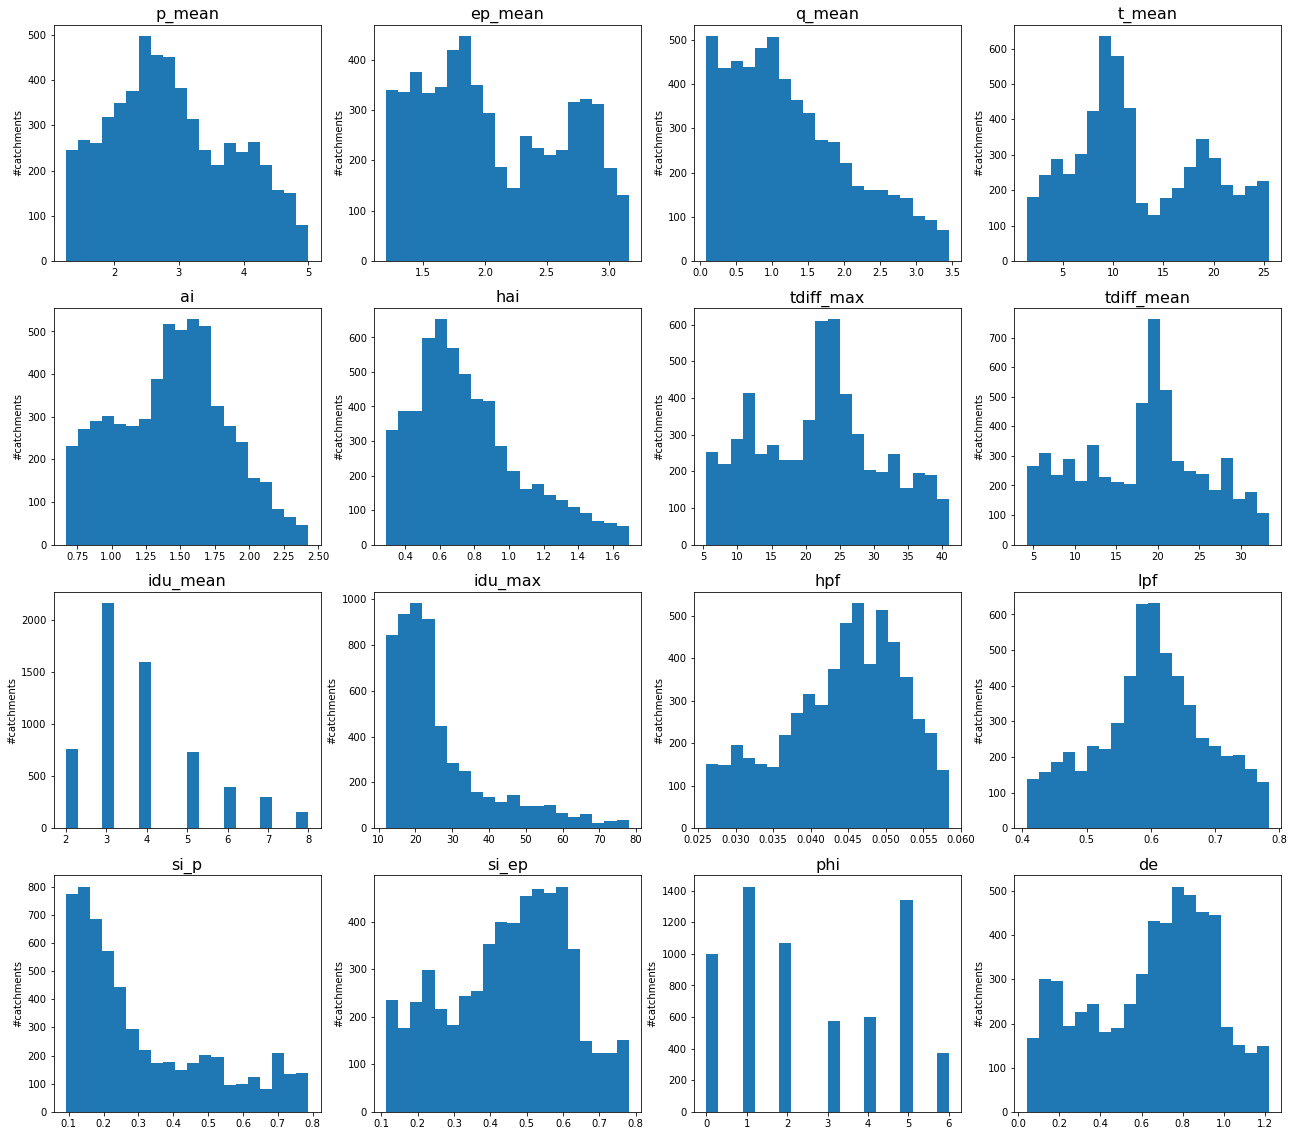

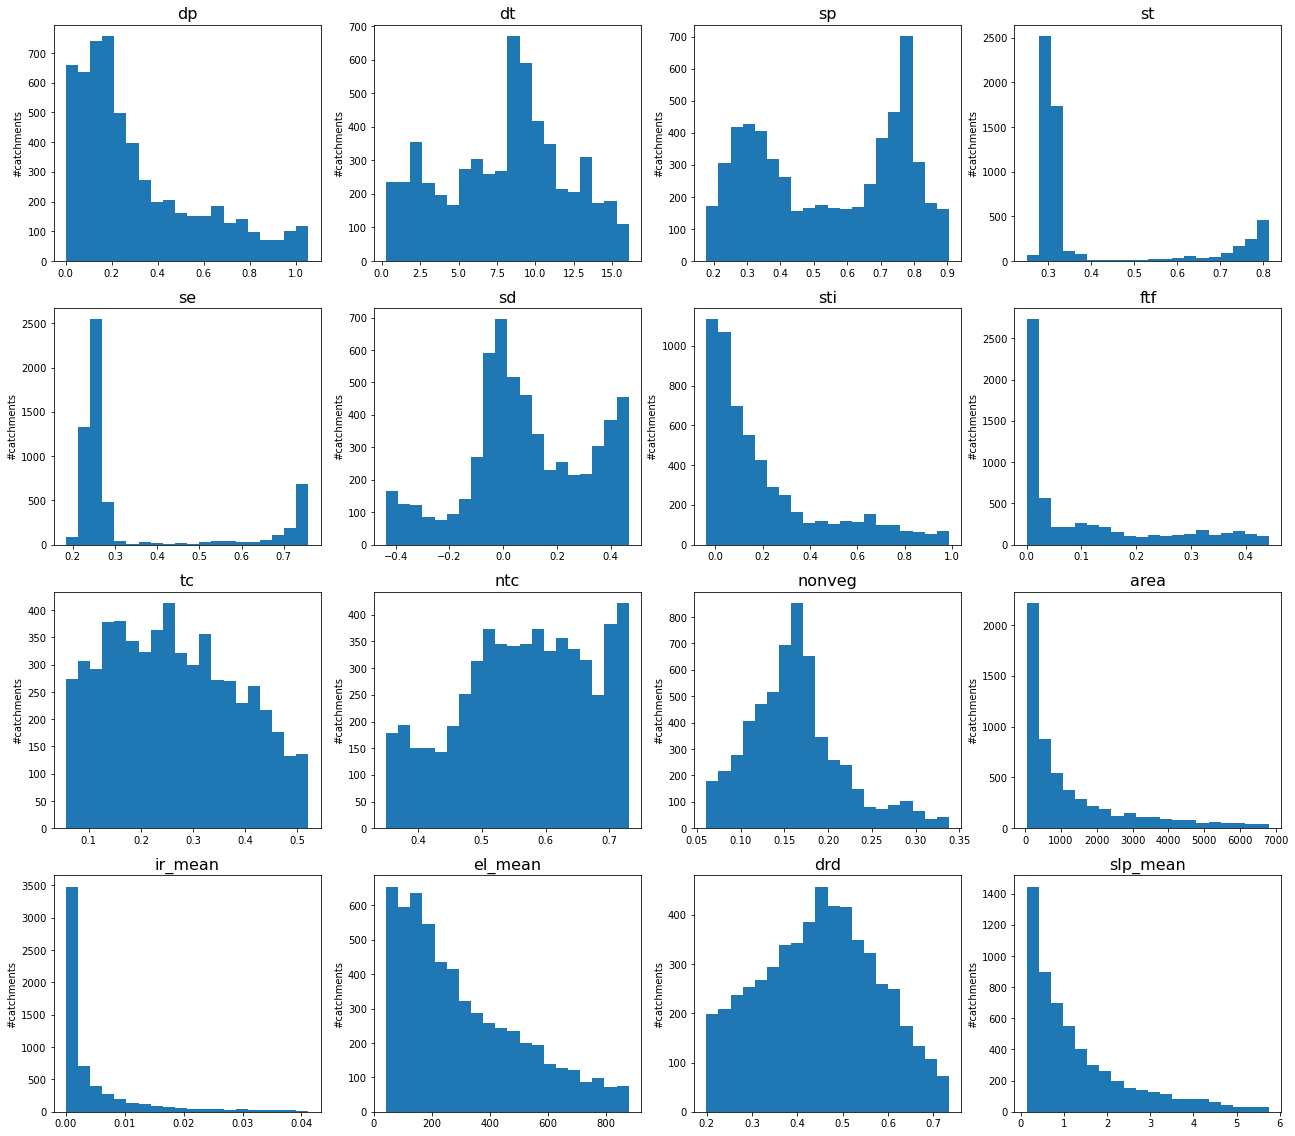

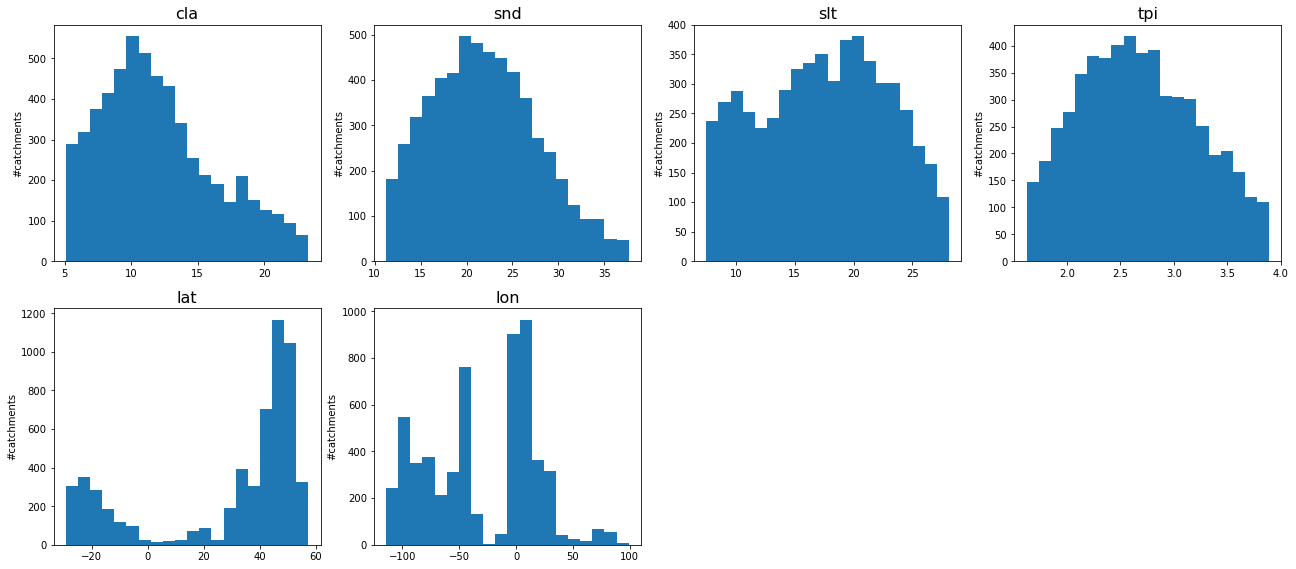

In [52]:
fig = plt.figure(figsize=(22,20))
for i in range(len(var[0:16])):
    bins = np.linspace(c[var[i]].quantile(0.05),c[var[i]].quantile(0.95),21)
    ax = fig.add_subplot(4,4,i+1)
    ax.hist(c[var[i]],bins=bins)
    ax.set_ylabel(f'#catchments')
    ax.set_title(f'{var[i]}',size=16)
    fig.savefig(f'{out_dir}/figures/catchment_overview/catch_characteristics_hist1.jpg',bbox_inches='tight',dpi=300)
    
fig = plt.figure(figsize=(22,20))
for i in range(len(var[16:32])):
    bins = np.linspace(c[var[i+16]].quantile(0.05),c[var[i+16]].quantile(0.95),21)
    ax = fig.add_subplot(4,4,i+1)
    ax.hist(c[var[i+16]],bins=bins)
    ax.set_ylabel(f'#catchments')
    ax.set_title(f'{var[i+16]}',size=16)
    fig.savefig(f'{out_dir}/figures/catchment_overview/catch_characteristics_hist2.jpg',bbox_inches='tight',dpi=300)
    
fig = plt.figure(figsize=(22,20))
for i in range(len(var[32:])):
    bins = np.linspace(c[var[i+32]].quantile(0.05),c[var[i+32]].quantile(0.95),21)
    ax = fig.add_subplot(4,4,i+1)
    ax.hist(c[var[i+32]],bins=bins)
    ax.set_ylabel(f'#catchments')
    ax.set_title(f'{var[i+32]}',size=16)
    fig.savefig(f'{out_dir}/figures/catchment_overview/catch_characteristics_hist3.jpg',bbox_inches='tight',dpi=300)

## 4. Sr mapping

In [4]:
#shapes
sh = gpd.read_file(f'{work_dir}/output/geo_catchments_sel_area_wb.shp')
sh.index = sh.catch_id
sh['centroid'] = sh.centroid

# sr dataframe
sr_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments.csv',index_col=0)
sr_df = sr_df[sr_df['20']>20]

# match sh and sr dfs
sh_sr = sh.loc[sr_df.index]
sh_sr['sr_20'] = sr_df['20']
sh_sr = sh_sr.drop(columns=['geometry'])
sh_sr = sh_sr.rename(columns={'centroid':'geometry'})

/tmp/ipykernel_1120893/3902150027.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sh['centroid'] = sh.centroid


KeyError: "['br_0000133', 'br_0000116', 'br_0000146', 'br_0000168', 'br_0000247', 'br_0000264', 'br_0000129', 'pa_0000001', 'om_0000006', 'br_0000132', 'br_0000117', 'om_0000005', 'br_0000121', 'om_0000001', 'br_0000088', 'br_0000101', 'br_0000139', 'om_0000002', 'br_0000049', 'br_0000118', 'br_0000167', 'br_0000025', 'br_0000093', 'br_0000126', 'om_0000004', 'br_0000145', 'br_0000166', 'ar_0000023', 'br_0000102', 'br_0000270', 'om_0000007', 'br_0000135', 'br_0000058', 'om_0000008', 'br_0000128'] not in index"

In [ ]:
lvls = np.linspace(0,600,13)
fig = plt.figure(figsize=(10,8))
# cm = plt.cm.get_cmap('jet')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
pl = sh_sr.plot(column='sr_20',ax=ax, markersize=1, cmap=cm,
           k=10,vmin=0,vmax=600,
           legend=True,
           legend_kwds={'label': "Sr(mm)", 'orientation': "horizontal", 'pad':0.02,'ticks':lvls})
ax.set_title(f'Sr T=20, >20mm, #catchments:{len(sr_df)}',size=20)
fig.savefig(f'{out_dir}/figures/catchment_overview/sr_map.jpg',bbox_inches='tight',dpi=300)


In [ ]:
# sr
bins = np.linspace(0,600,25)
bins2 = np.linspace(0,600,13)
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.hist(sr_df['20'],bins=bins)
ax.set_xticks(bins2)
ax.set_xlabel('Sr (-)')
ax.set_ylabel('# catchments (-)')
ax.set_title(f'catchment Sr>20mm: #{len(sr_df)}')
fig.savefig(f'{out_dir}/figures/catchment_overview/sr_hist.jpg',bbox_inches='tight',dpi=300)


In [7]:
sr_df['20'].max()

870.7095427446989

Text(0, 0.5, 'minmax rz year')

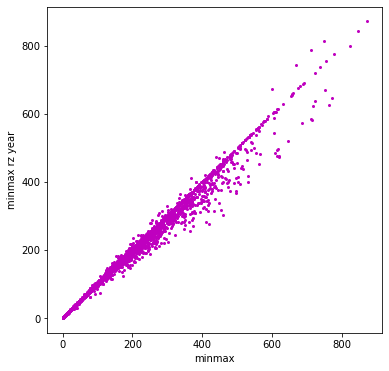

In [8]:
# plt sr minmax vd dt minmax rootzone year
sr1_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments_maxmin.csv',index_col=0)
sr2_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments.csv',index_col=0)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(sr1_df['20'],sr2_df['20'],'mo',markersize=2)
ax.set_xlabel('minmax')
ax.set_ylabel('minmax rz year')

### 5. Budyko

In [330]:
# get Sr
sr_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments.csv',index_col=0)
sr = sr_df['20']
sr = sr[sr>20]

# temporary drop these catchments because something went wrong with catchment-characteristic calculation
sr = sr.drop(index=['br_0000133', 'br_0000116', 'br_0000146', 'br_0000168', 'br_0000247', 'br_0000264', 'br_0000129', 'pa_0000001', 'om_0000006', 'br_0000132', 'br_0000117', 'om_0000005', 'br_0000121', 'om_0000001', 'br_0000088', 'br_0000101', 'br_0000139', 'om_0000002', 'br_0000049', 'br_0000118', 'br_0000167', 'br_0000025', 'br_0000093', 'br_0000126', 'om_0000004', 'br_0000145', 'br_0000166', 'br_0000102', 'br_0000270', 'om_0000007', 'br_0000135', 'br_0000058', 'om_0000008', 'br_0000128'])

In [331]:
# get catchment characteristics
c = pd.read_csv(f'{out_dir}/catchment_characteristics_sel_area_wb.csv',index_col=0)
c = c.loc[sr.index]
x = c.ep_mean/c.p_mean
y = (c.p_mean-c.q_mean)/c.p_mean
x = x.dropna() # a few points with nan for AI
y = y[x.index]
c = c.loc[x.index]

In [332]:
var = c.columns
var = var.drop(['p_mean','ep_mean','q_mean','t_mean','ai','hai','hpd_mean','hpd_max','el_min','el_max'])
var = np.concatenate((var.values,['sr']))
var

array(['tdiff_max', 'tdiff_mean', 'idu_mean', 'idu_max', 'hpf', 'lpf',
       'si_p', 'si_ep', 'phi', 'de', 'dp', 'dt', 'sp', 'st', 'se', 'sd',
       'sti', 'ftf', 'tc', 'ntc', 'nonveg', 'area', 'ir_mean', 'el_mean',
       'drd', 'slp_mean', 'cla', 'snd', 'slt', 'tpi', 'lat', 'lon', 'sr'],
      dtype=object)

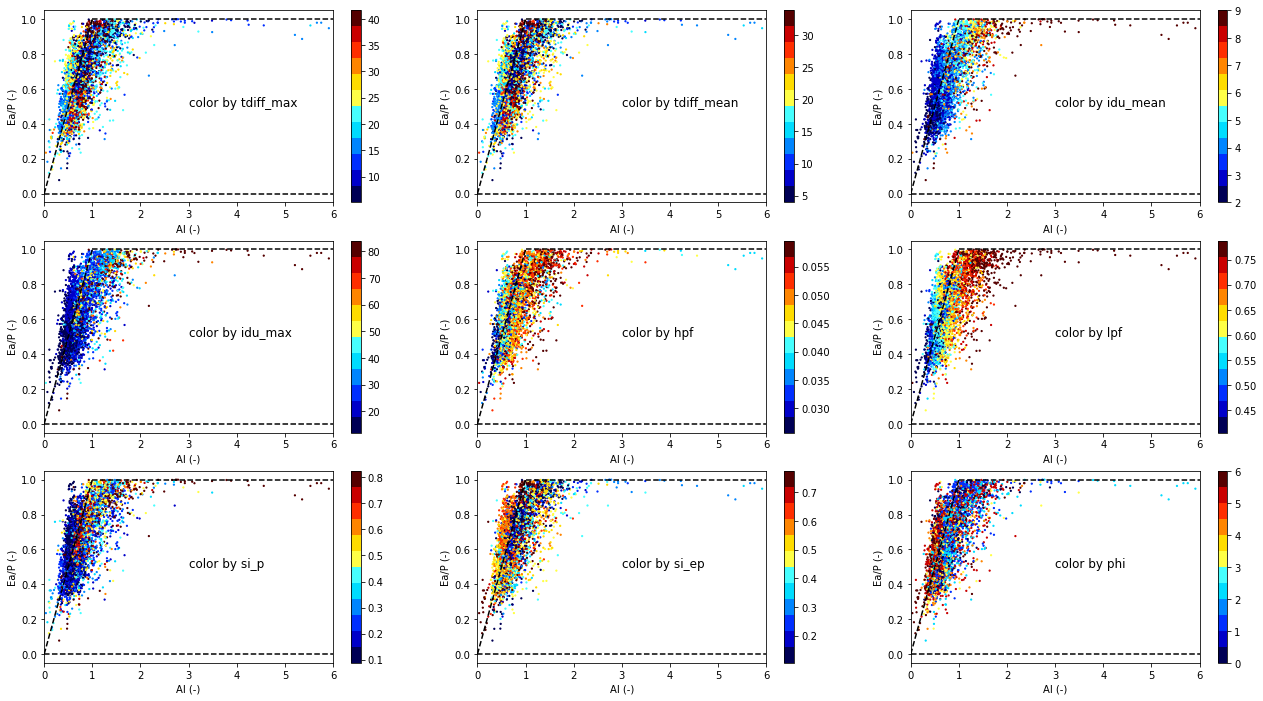

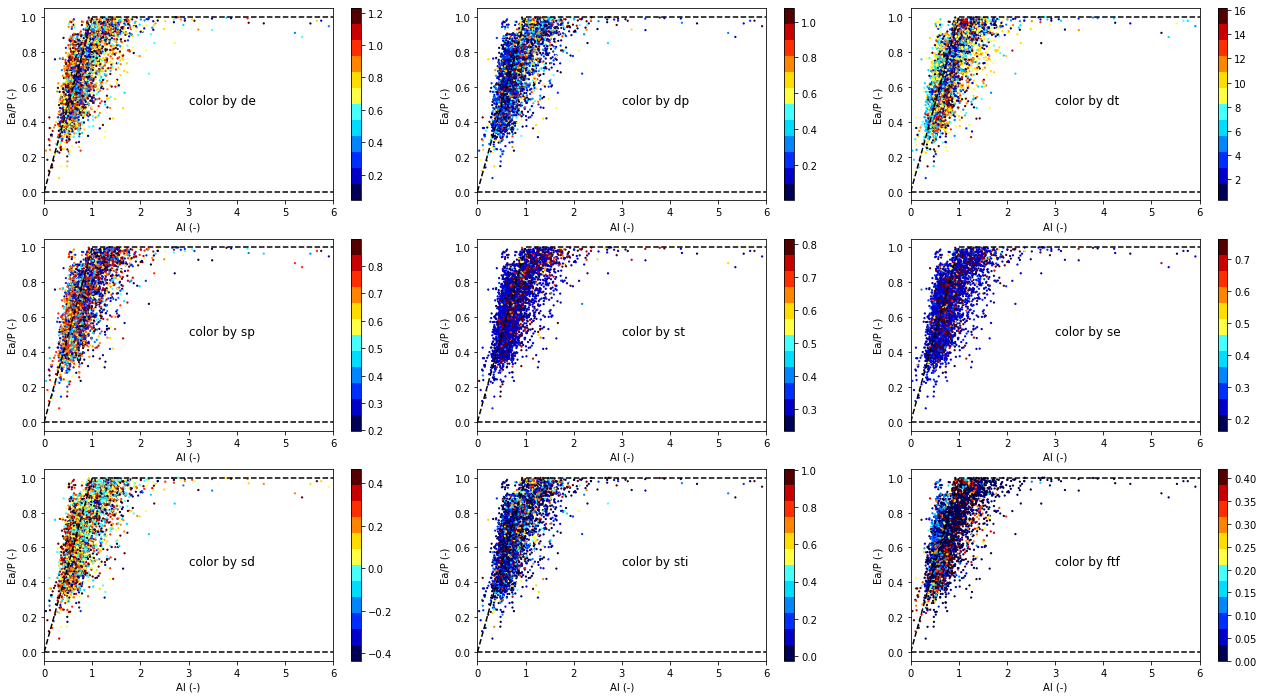

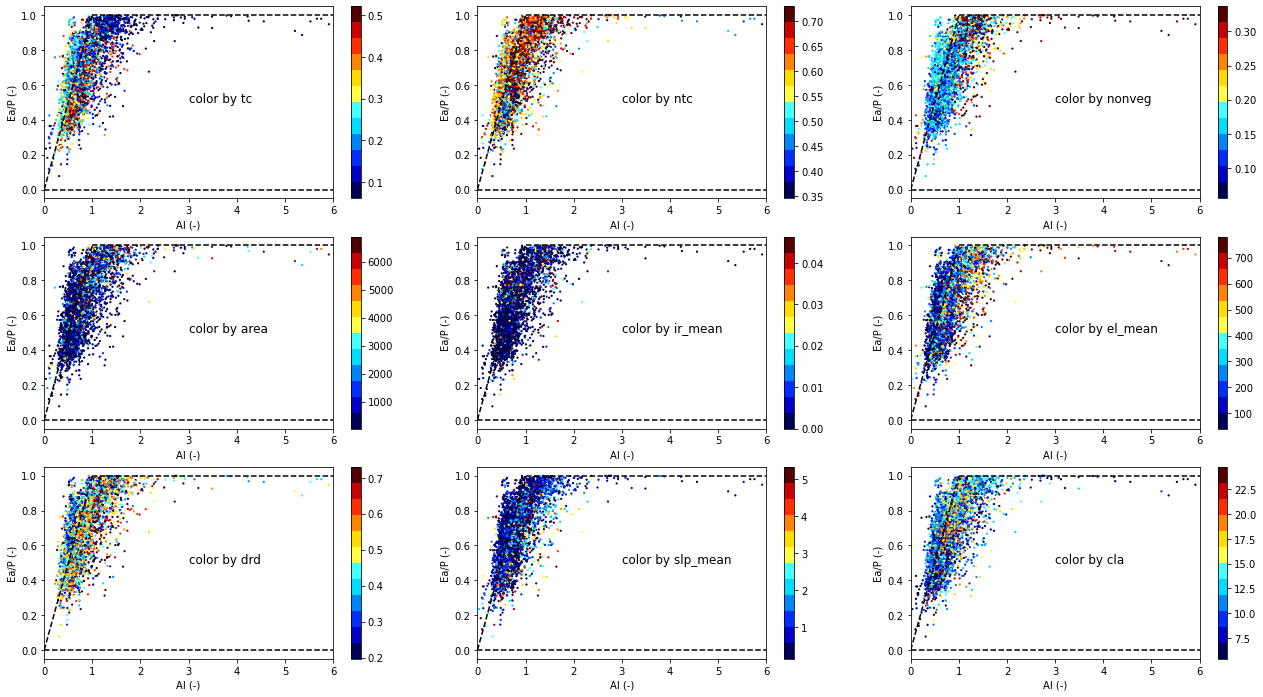

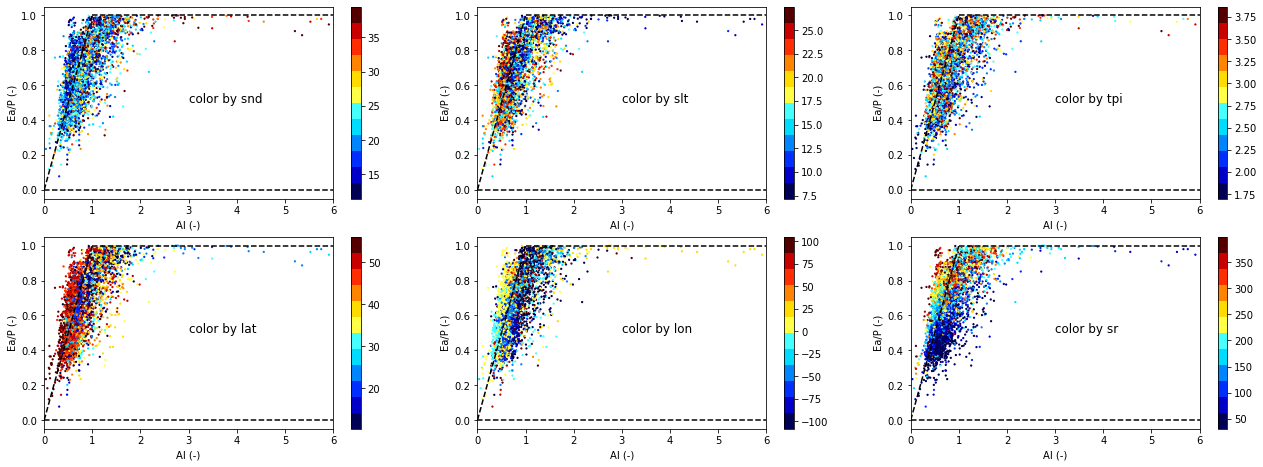

In [333]:
# plot budyko all points
fig = plt.figure(figsize=(22,12))
for i in range(len(var[0:9])):
    ax = fig.add_subplot(3,3,i+1)
    k=c[var[i]]
    f=ax.scatter(x,y,c=k,s=1.5,cmap=cm,vmin=k.quantile(0.05),vmax=k.quantile(0.95))
    plt.colorbar(f)
    ax.plot([0,1],[0,1], '--k')
    ax.plot([1,12],[1,1], '--k')
    ax.plot([0,12],[0,0], '--k')
    ax.set_xlim(0,6)
    ax.set_xlabel('AI (-)')
    ax.set_ylabel('Ea/P (-)')
    ax.annotate(f'color by {var[i]}',(3,0.5),size=12)
fig.savefig(f'{out_dir}/figures/catchment_overview/catch_characteristics_budyko1.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(22,12))
for i in range(len(var[9:18])):
    ax = fig.add_subplot(3,3,i+1)
    k=c[var[i+9]]
    f=ax.scatter(x,y,c=k,s=1.5,cmap=cm,vmin=k.quantile(0.05),vmax=k.quantile(0.95))
    plt.colorbar(f)
    ax.plot([0,1],[0,1], '--k')
    ax.plot([1,12],[1,1], '--k')
    ax.plot([0,12],[0,0], '--k')
    ax.set_xlim(0,6)
    ax.set_xlabel('AI (-)')
    ax.set_ylabel('Ea/P (-)')
    ax.annotate(f'color by {var[i+9]}',(3,0.5),size=12)
fig.savefig(f'{out_dir}/figures/catchment_overview/catch_characteristics_budyko2.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(22,12))
for i in range(len(var[18:27])):
    ax = fig.add_subplot(3,3,i+1)
    k=c[var[i+18]]
    f=ax.scatter(x,y,c=k,s=1.5,cmap=cm,vmin=k.quantile(0.05),vmax=k.quantile(0.95))
    plt.colorbar(f)
    ax.plot([0,1],[0,1], '--k')
    ax.plot([1,12],[1,1], '--k')
    ax.plot([0,12],[0,0], '--k')
    ax.set_xlim(0,6)
    ax.set_xlabel('AI (-)')
    ax.set_ylabel('Ea/P (-)')
    ax.annotate(f'color by {var[i+18]}',(3,0.5),size=12)
fig.savefig(f'{out_dir}/figures/catchment_overview/catch_characteristics_budyko3.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(22,12))
for i in range(len(var[27:])):
    ax = fig.add_subplot(3,3,i+1)
    if (var[i+27]=='sr'):
        k=sr
    else:
        k=c[var[i+27]]
    if (var[i+27]=='lat'):
        k=abs(k)
    f=ax.scatter(x,y,c=k,s=1.5,cmap=cm,vmin=k.quantile(0.05),vmax=k.quantile(0.95))
    plt.colorbar(f)
    ax.plot([0,1],[0,1], '--k')
    ax.plot([1,12],[1,1], '--k')
    ax.plot([0,12],[0,0], '--k')
    ax.set_xlim(0,6)
    ax.set_xlabel('AI (-)')
    ax.set_ylabel('Ea/P (-)')
    ax.annotate(f'color by {var[i+27]}',(3,0.5),size=12)
fig.savefig(f'{out_dir}/figures/catchment_overview/catch_characteristics_budyko4.jpg',bbox_inches='tight',dpi=300)

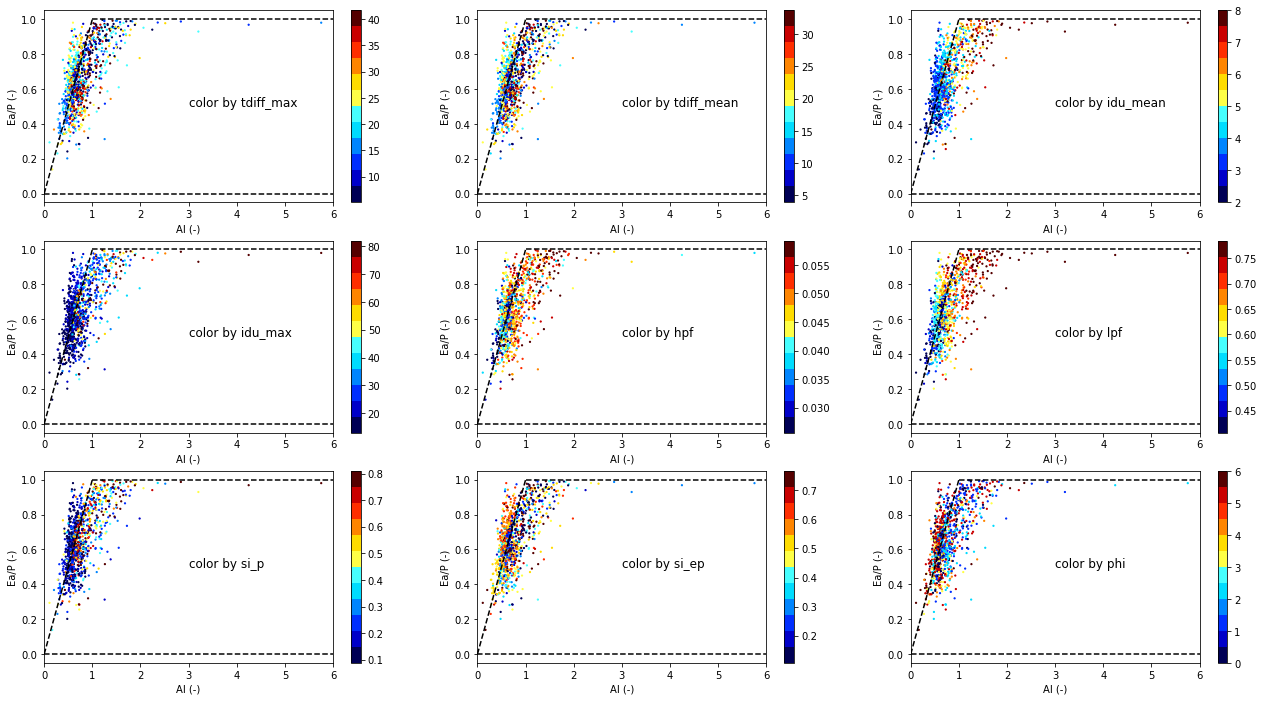

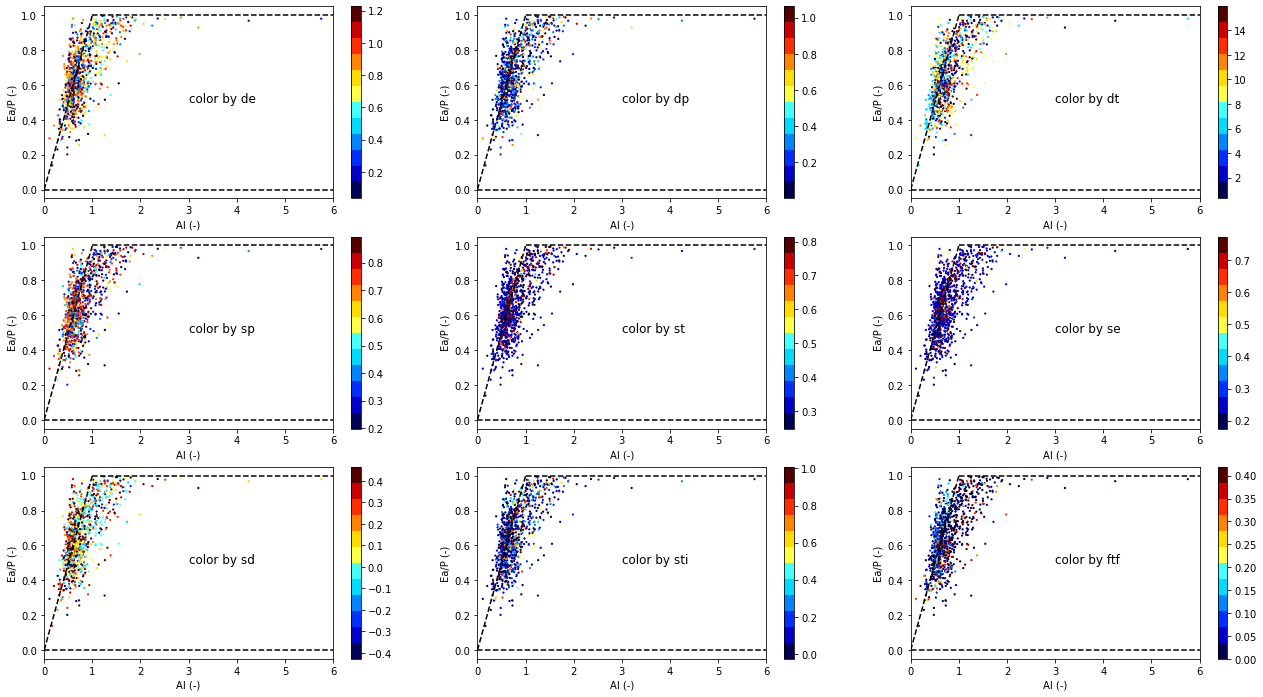

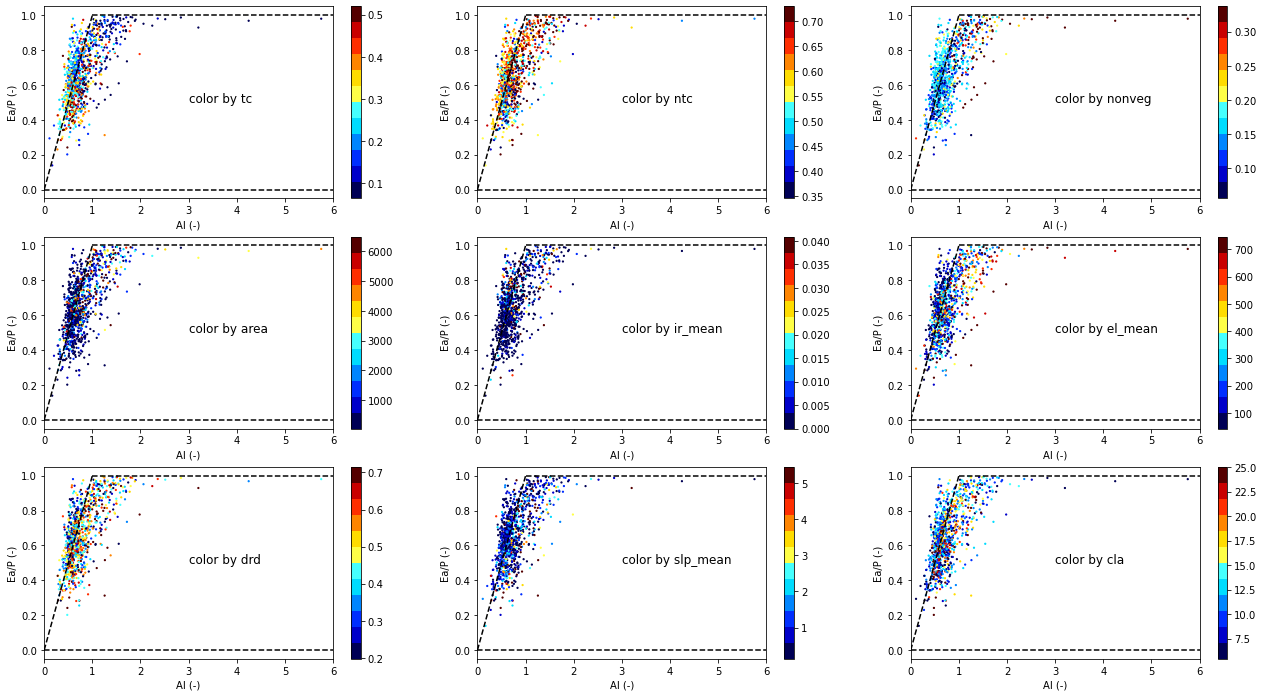

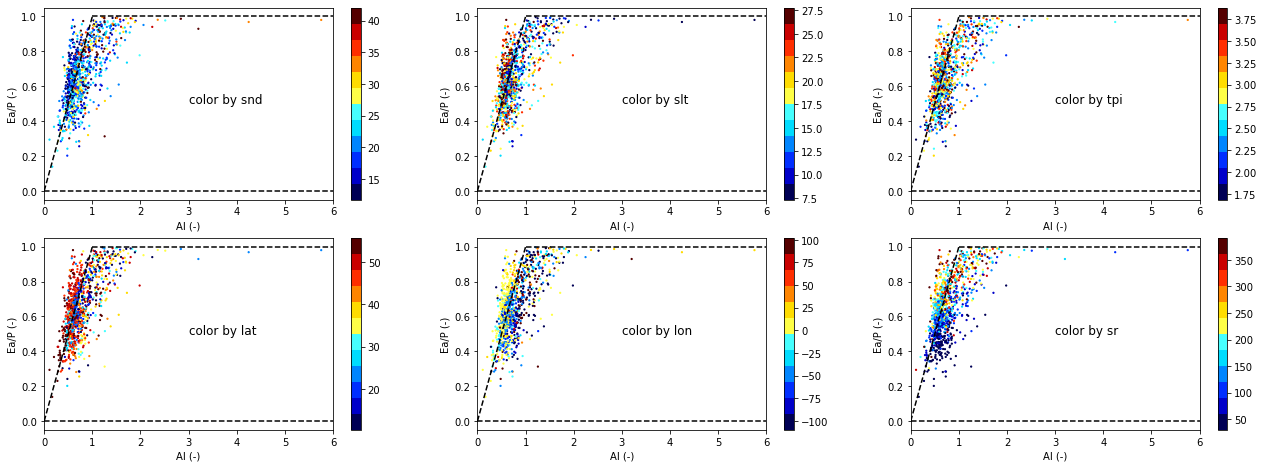

In [334]:
cs = c.sample(1000)
ys = y.loc[cs.index]
xs = x.loc[cs.index]
srs = sr.loc[cs.index]

# plot budyko sample of points
fig = plt.figure(figsize=(22,12))
for i in range(len(var[0:9])):
    ax = fig.add_subplot(3,3,i+1)
    k=cs[var[i]]
    f=ax.scatter(xs,ys,c=k,s=1.5,cmap=cm,vmin=k.quantile(0.05),vmax=k.quantile(0.95))
    plt.colorbar(f)
    ax.plot([0,1],[0,1], '--k')
    ax.plot([1,12],[1,1], '--k')
    ax.plot([0,12],[0,0], '--k')
    ax.set_xlim(0,6)
    ax.set_xlabel('AI (-)')
    ax.set_ylabel('Ea/P (-)')
    ax.annotate(f'color by {var[i]}',(3,0.5),size=12)
fig.savefig(f'{out_dir}/figures/catchment_overview/catch_characteristics_budykos1.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(22,12))
for i in range(len(var[9:18])):
    ax = fig.add_subplot(3,3,i+1)
    k=cs[var[i+9]]
    f=ax.scatter(xs,ys,c=k,s=1.5,cmap=cm,vmin=k.quantile(0.05),vmax=k.quantile(0.95))
    plt.colorbar(f)
    ax.plot([0,1],[0,1], '--k')
    ax.plot([1,12],[1,1], '--k')
    ax.plot([0,12],[0,0], '--k')
    ax.set_xlim(0,6)
    ax.set_xlabel('AI (-)')
    ax.set_ylabel('Ea/P (-)')
    ax.annotate(f'color by {var[i+9]}',(3,0.5),size=12)
fig.savefig(f'{out_dir}/figures/catchment_overview/catch_characteristics_budykos2.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(22,12))
for i in range(len(var[18:27])):
    ax = fig.add_subplot(3,3,i+1)
    k=cs[var[i+18]]
    f=ax.scatter(xs,ys,c=k,s=1.5,cmap=cm,vmin=k.quantile(0.05),vmax=k.quantile(0.95))
    plt.colorbar(f)
    ax.plot([0,1],[0,1], '--k')
    ax.plot([1,12],[1,1], '--k')
    ax.plot([0,12],[0,0], '--k')
    ax.set_xlim(0,6)
    ax.set_xlabel('AI (-)')
    ax.set_ylabel('Ea/P (-)')
    ax.annotate(f'color by {var[i+18]}',(3,0.5),size=12)
fig.savefig(f'{out_dir}/figures/catchment_overview/catch_characteristics_budykos3.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(22,12))
for i in range(len(var[27:])):
    ax = fig.add_subplot(3,3,i+1)
    if (var[i+27]=='sr'):
        k=srs
    else:
        k=cs[var[i+27]]
    if (var[i+27]=='lat'):
        k=abs(k)
    f=ax.scatter(xs,ys,c=k,s=1.5,cmap=cm,vmin=k.quantile(0.05),vmax=k.quantile(0.95))
    plt.colorbar(f)
    ax.plot([0,1],[0,1], '--k')
    ax.plot([1,12],[1,1], '--k')
    ax.plot([0,12],[0,0], '--k')
    ax.set_xlim(0,6)
    ax.set_xlabel('AI (-)')
    ax.set_ylabel('Ea/P (-)')
    ax.annotate(f'color by {var[i+27]}',(3,0.5),size=12)
fig.savefig(f'{out_dir}/figures/catchment_overview/catch_characteristics_budykos4.jpg',bbox_inches='tight',dpi=300)


In [270]:
k=c.p_mean
df = pd.DataFrame(index=k.index, columns=['p_mean','bin','occ'])
df.p_mean = k
r = np.linspace(k.min(),k.max(),10)

for i in range(len(df)):
    for m in range(len(r)-1):
        if (df['p_mean'][i]>r[m]) & (df['p_mean'][i]<r[m+1]):
            df['bin']=m

In [271]:
for i in range(len(df)):
    # print(i)
    for m in range(len(r)-1):
        # print(r[m])
        # print(r[m+1])
        if ((df['p_mean'][i]>r[m]) & (df['p_mean'][i]<r[m+1])):
            # print(m)
            df['bin'][i]=m

/tmp/ipykernel_2185076/2958847988.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bin'][i]=m


In [272]:
counts = df['bin'].value_counts()
for i in range(len(df)):
    if (df['bin'][i]==0):
        df['occ'][i]=1-counts[counts.index==0].values[0]/counts.sum()
    if (df['bin'][i]==1):
        df['occ'][i]=1-counts[counts.index==1].values[0]/counts.sum()
    if (df['bin'][i]==2):
        df['occ'][i]=1-counts[counts.index==2].values[0]/counts.sum()
    if (df['bin'][i]==3):
        df['occ'][i]=1-counts[counts.index==3].values[0]/counts.sum()
    if (df['bin'][i]==4):
        df['occ'][i]=1-counts[counts.index==4].values[0]/counts.sum()
    if (df['bin'][i]==5):
        df['occ'][i]=1-counts[counts.index==4].values[0]/counts.sum()
    if (df['bin'][i]==6):
        df['occ'][i]=1-counts[counts.index==4].values[0]/counts.sum()

/tmp/ipykernel_2185076/521255910.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['occ'][i]=1-counts[counts.index==1].values[0]/counts.sum()
/tmp/ipykernel_2185076/521255910.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['occ'][i]=1-counts[counts.index==0].values[0]/counts.sum()
/tmp/ipykernel_2185076/521255910.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['occ'][i]=1-counts[counts.index==2].values[0]/counts.sum(

In [284]:
weights = abs((df.occ-df.occ.mean()))/df.occ.std()

In [285]:
weights

catch_id
za_0000167    0.946121
es_0000787    1.145624
br_0001831    0.553225
es_0001076    1.145624
de_0000289    0.553225
                ...   
us_0006131    0.946121
fr_0000086    0.946121
ca_0001025    0.946121
br_0001145    0.946121
138113A       0.946121
Name: occ, Length: 4640, dtype: object

In [286]:
a=df['p_mean'].sample(1000,weights=weights)

In [287]:
a

catch_id
ca_0004797    1.251892
fr_0001291    2.665946
es_0000914    1.200891
ca_0000125    3.374160
es_0001015    2.351474
                ...   
de_0000645    2.693709
ie_0000015    3.153402
br_0001891    4.801097
ru_0000317    1.780895
at_0000113    4.727466
Name: p_mean, Length: 1000, dtype: float64

(array([105., 269., 339., 114., 110.,  33.,  15.,   8.,   3.,   4.]),
 array([ 0.42475846,  1.41453594,  2.40431342,  3.3940909 ,  4.38386838,
         5.37364586,  6.36342334,  7.35320082,  8.3429783 ,  9.33275578,
        10.32253326]),
 <BarContainer object of 10 artists>)

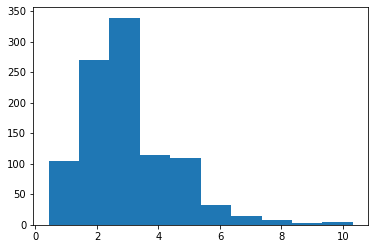

In [288]:
plt.hist(a)

(array([5.810e+02, 2.107e+03, 1.218e+03, 5.950e+02, 9.000e+01, 2.700e+01,
        1.400e+01, 7.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.36025829,  1.64782554,  2.93539279,  4.22296003,  5.51052728,
         6.79809453,  8.08566178,  9.37322903, 10.66079627, 11.94836352,
        13.23593077]),
 <BarContainer object of 10 artists>)

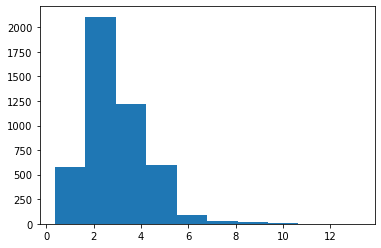

In [289]:
plt.hist(c.p_mean)

In [193]:
k.columns

AttributeError: 'Series' object has no attribute 'columns'

### 4. plot sr vs descriptors

In [335]:
# get Sr
sr_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments.csv',index_col=0)
sr = sr_df['20']
sr = sr[sr>20]

# temporary drop these catchments because something went wrong with catchment-characteristic calculation
sr = sr.drop(index=['br_0000133', 'br_0000116', 'br_0000146', 'br_0000168', 'br_0000247', 'br_0000264', 'br_0000129', 'pa_0000001', 'om_0000006', 'br_0000132', 'br_0000117', 'om_0000005', 'br_0000121', 'om_0000001', 'br_0000088', 'br_0000101', 'br_0000139', 'om_0000002', 'br_0000049', 'br_0000118', 'br_0000167', 'br_0000025', 'br_0000093', 'br_0000126', 'om_0000004', 'br_0000145', 'br_0000166', 'br_0000102', 'br_0000270', 'om_0000007', 'br_0000135', 'br_0000058', 'om_0000008', 'br_0000128'])

In [336]:
c = pd.read_csv(f'{out_dir}/catchment_characteristics_sel_area_wb.csv',index_col=0)
c = c.loc[sr.index]

In [347]:
var = c.columns
var = var.drop(['q_mean','hpd_mean','hpd_max','el_min','el_max','lon'])
var

Index(['p_mean', 'ep_mean', 't_mean', 'ai', 'hai', 'tdiff_max', 'tdiff_mean',
       'idu_mean', 'idu_max', 'hpf', 'lpf', 'si_p', 'si_ep', 'phi', 'de', 'dp',
       'dt', 'sp', 'st', 'se', 'sd', 'sti', 'ftf', 'tc', 'ntc', 'nonveg',
       'area', 'ir_mean', 'el_mean', 'drd', 'slp_mean', 'cla', 'snd', 'slt',
       'tpi', 'lat'],
      dtype='object')

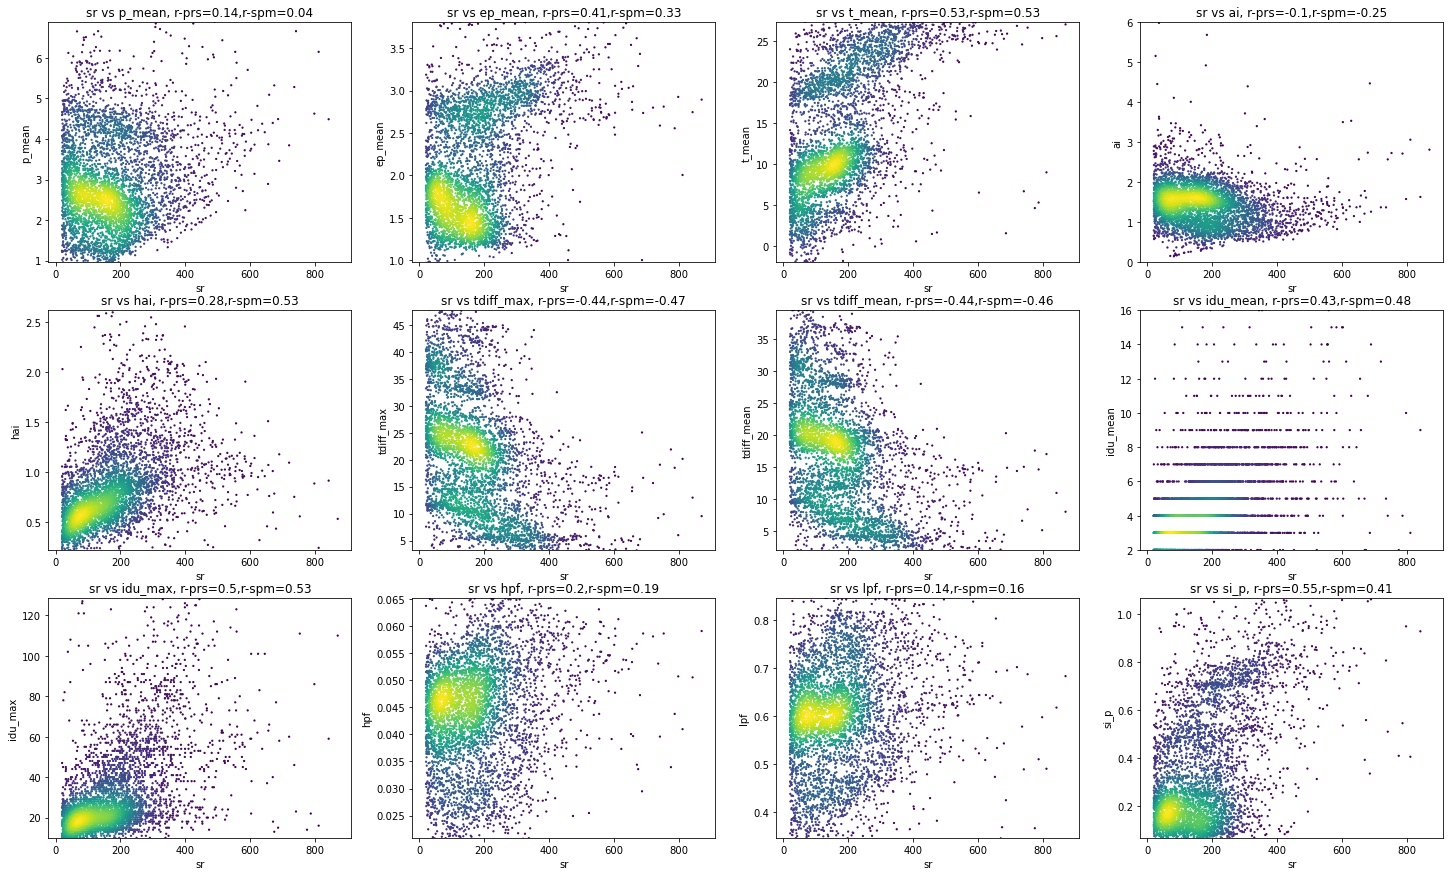

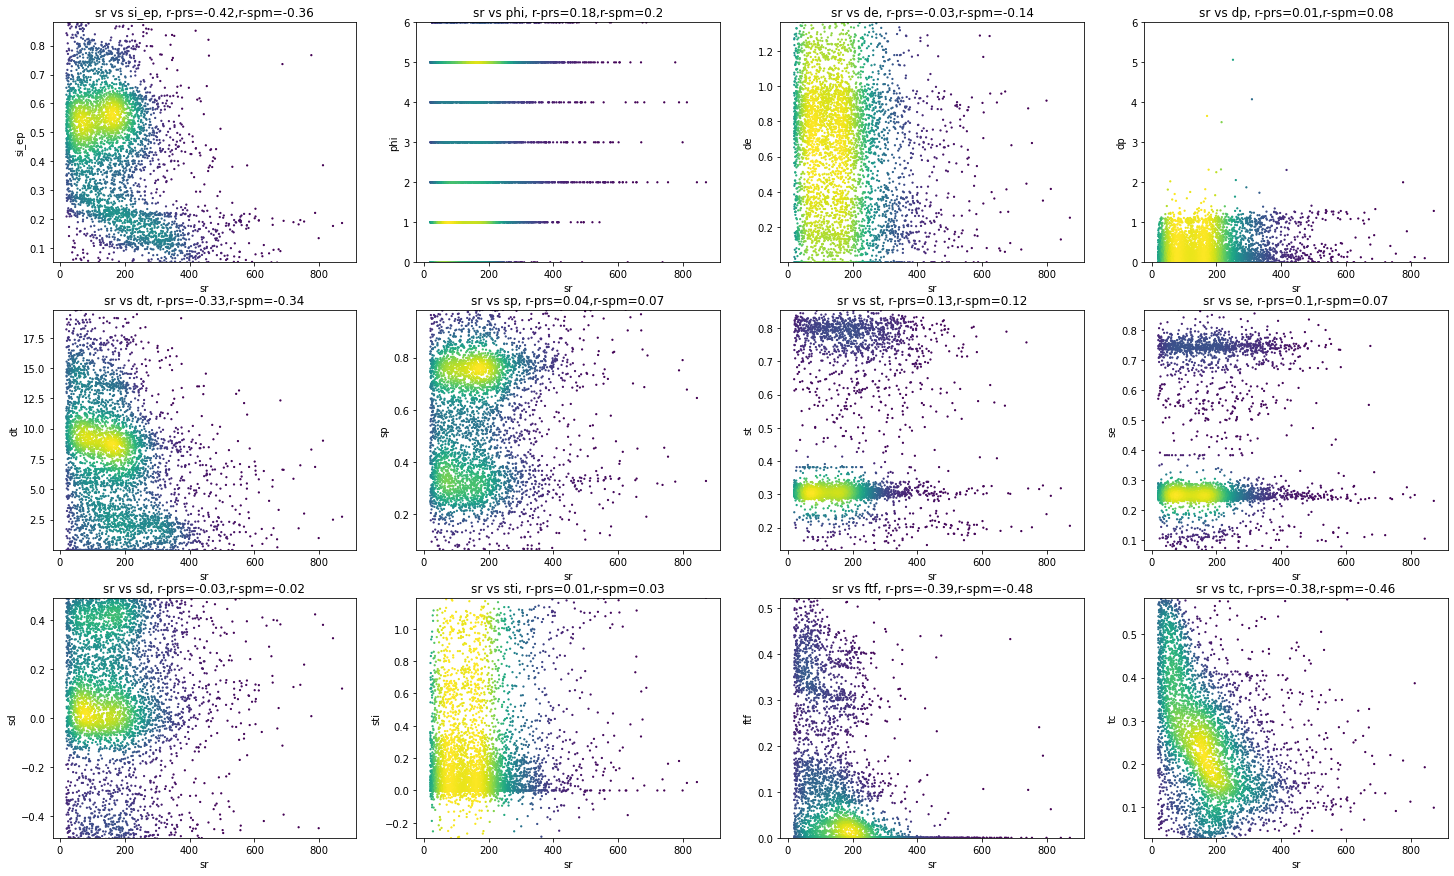

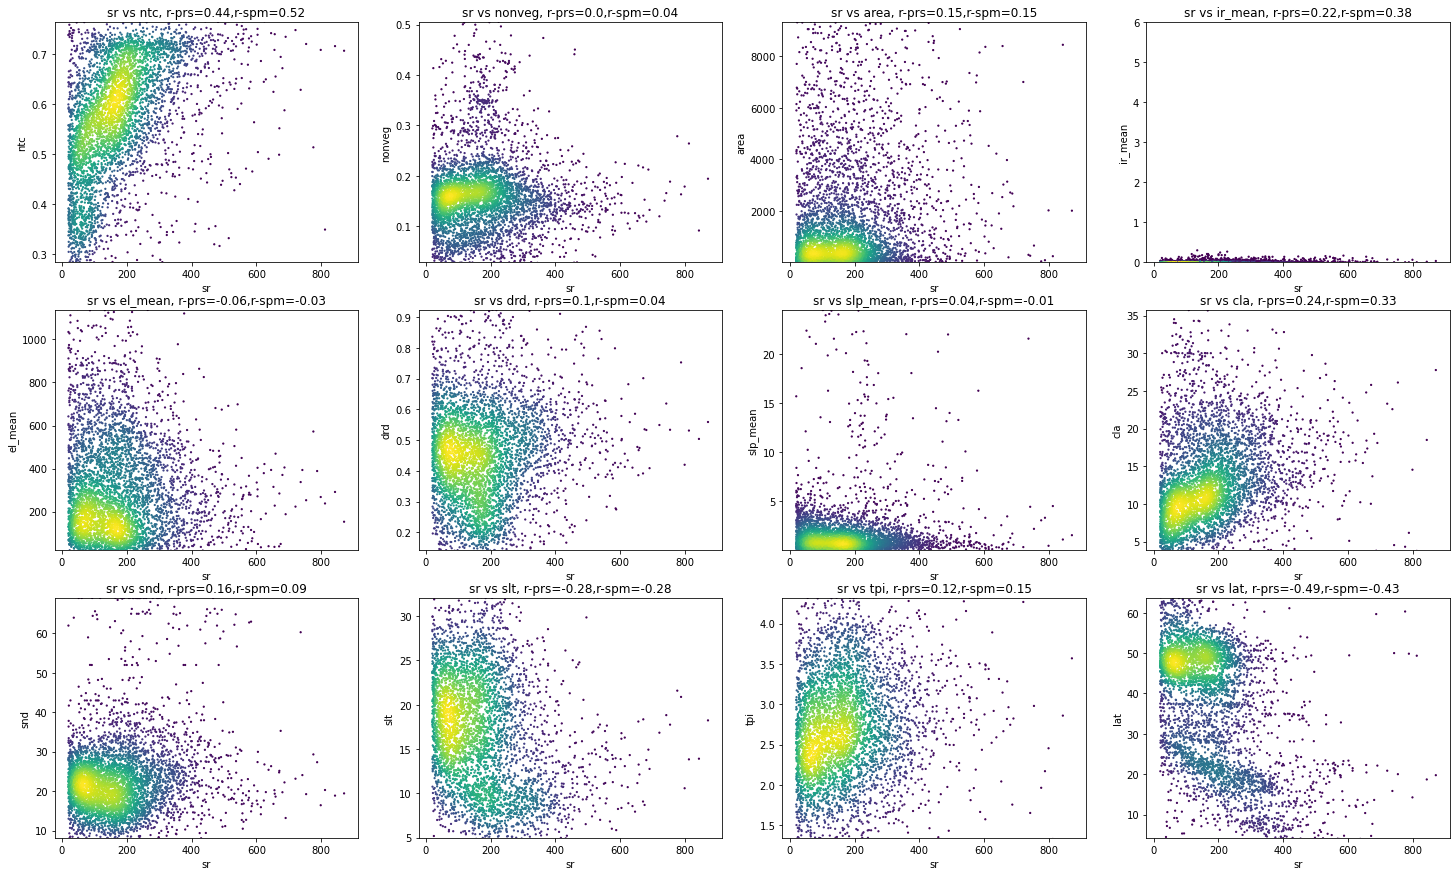

In [349]:
fig = plt.figure(figsize=(25,15))
for i in range(len(var[:12])):
    if ((var[i])=='lat'):
        c[var[i]] = abs(c[var[i]])
    
    # calculate point density
    xy = np.vstack([sr,c[var[i]]])
    z = gaussian_kde(xy)(xy)
    
    rp = np.round(np.corrcoef(sr,c[var[i]])[1,0],2)
    rp = np.round(stats.pearsonr(sr,c[var[i]])[0],2)
    rs = np.round(stats.spearmanr(sr,c[var[i]])[0],2)
    ax = fig.add_subplot(3,4,i+1)
    f = ax.scatter(sr,c[var[i]],c=z,s=1.5)
    ax.set_ylim(c[var[i]].quantile(0.01),c[var[i]].quantile(0.99))
    ax.set_xlabel('sr')
    ax.set_ylabel(f'{var[i]}')
    ax.set_title(f'sr vs {var[i]}, r-prs={rp},r-spm={rs}')
    if (var[i]=='ai'):
        ax.set_ylim(0,6)
fig.savefig(f'{out_dir}/figures/catchment_overview/catch_characteristics_vs_sr1.jpg',bbox_inches='tight',dpi=300)


fig = plt.figure(figsize=(25,15))
for i in range(len(var[12:24])):
    k = c[var[i+12]]
    sr2 = sr
    if ((var[i+12])=='lat'):
        k = abs(k)
        
    if k.isnull().values.any():
        k = k.dropna()
        sr2 = sr2.loc[k.index]
    
    # calculate point density
    xy = np.vstack([sr2,k])
    z = gaussian_kde(xy)(xy)
    
    rp = np.round(np.corrcoef(sr2,k)[1,0],2)
    rp = np.round(stats.pearsonr(sr2,k)[0],2)
    rs = np.round(stats.spearmanr(sr2,k)[0],2)
    ax = fig.add_subplot(3,4,i+1)
    f = ax.scatter(sr2,k,c=z,s=1.5)
    ax.set_ylim(k.quantile(0.01),k.quantile(0.99))
    ax.set_xlabel('sr')
    ax.set_ylabel(f'{var[i+12]}')
    ax.set_title(f'sr vs {var[i+12]}, r-prs={rp},r-spm={rs}')
    if (var[i]=='ai'):
        ax.set_ylim(0,6)
fig.savefig(f'{out_dir}/figures/catchment_overview/catch_characteristics_vs_sr2.jpg',bbox_inches='tight',dpi=300)


fig = plt.figure(figsize=(25,15))
for i in range(len(var[24:])):
    k = c[var[i+24]]
    sr2 = sr
    if ((var[i+24])=='lat'):
        k = abs(k)
        
    if k.isnull().values.any():
        k = k.dropna()
        sr2 = sr2.loc[k.index]
    
    # calculate point density
    xy = np.vstack([sr2,k])
    z = gaussian_kde(xy)(xy)
    
    rp = np.round(np.corrcoef(sr2,k)[1,0],2)
    rp = np.round(stats.pearsonr(sr2,k)[0],2)
    rs = np.round(stats.spearmanr(sr2,k)[0],2)
    ax = fig.add_subplot(3,4,i+1)
    f = ax.scatter(sr2,k,c=z,s=1.5)
    ax.set_ylim(k.quantile(0.01),k.quantile(0.99))
    ax.set_xlabel('sr')
    ax.set_ylabel(f'{var[i+24]}')
    ax.set_title(f'sr vs {var[i+24]}, r-prs={rp},r-spm={rs}')
    if (var[i]=='ai'):
        ax.set_ylim(0,6)
fig.savefig(f'{out_dir}/figures/catchment_overview/catch_characteristics_vs_sr3.jpg',bbox_inches='tight',dpi=300)

## 5. compare my sr estimates to stocker and lan sr estimates 

In [ ]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# here I define the colors with RGB color codes
a = 255/255
b = 220/255
c = 201/255
d = 133/255
e = 85/255
f = 70/255
g = 46/255

c1 = (e,0,0)
c2 = (c,0,0)
c3 = (a,g,0)
c4 = (a,d,0)
c5 = (a,b,0)
c6 = (a,a,f)
c7 = (f,a,a)
c8 = (0,b,a)
c9 = (0,d,a)
c10 = (0,g,a)
c11 = (0,0,c)
c12 = (0,0,e)

# here I make an array of the colors I like to use
colors=[c12,c11,c10,c9,c8,c7,c6,c5,c4,c3,c2,c1]

# here I make a colormap from the colors above
cm = ListedColormap(colors)

# here I load some of my data
s = xr.open_dataset(f'{work_dir}/data/reference_sr/stocker/cwdx80.nc')
s = s.cwdx80

# here I make a plot with the colormap above, the size of lvls (indicating my steps of the colormap) should be the same as the amounts of colors in my colormap
lvls = np.arange(0,600,50) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=sr_df['60'],s=0.5,cmap=cm,vmin=0,vmax=600)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',extend='max', pad=0.02, ticks = lvls)
ax.set_title(f'Sr T=60, >20mm, #catchments:{len(sr_df)}',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_catchments_t60.jpg',bbox_inches='tight',dpi=300)

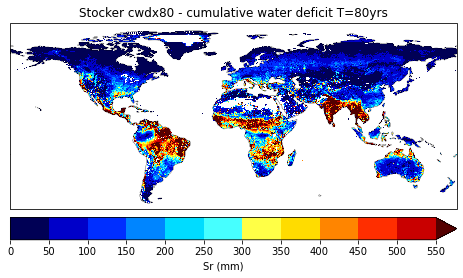

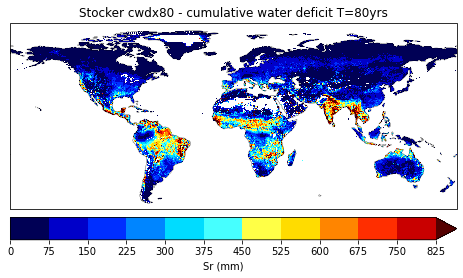

In [79]:
s = xr.open_dataset(f'{work_dir}/data/reference_sr/stocker/cwdx80.nc')
s = s.cwdx80

lvls = np.arange(0,600,50) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = s.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'Stocker cwdx80 - cumulative water deficit T=80yrs')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_stocker_cwdx80.jpg',bbox_inches='tight',dpi=300)

lvls = np.arange(0,900,75) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = s.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'Stocker cwdx80 - cumulative water deficit T=80yrs')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_stocker_cwdx80_v2.jpg',bbox_inches='tight',dpi=300)

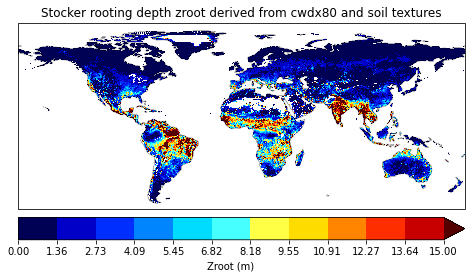

In [80]:
sd = xr.open_dataset(f'{work_dir}/data/reference_sr/stocker/zroot_cwd80.nc')
sd = sd.zroot_cwd80/1000 #convert to meters

lvls = np.linspace(0,15,12) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = sd.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Zroot (m)', pad=0.02, ticks = lvls)
ax.set_title(f'Stocker rooting depth zroot derived from cwdx80 and soil textures')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_stocker_zroot_cwd80.jpg',bbox_inches='tight',dpi=300)

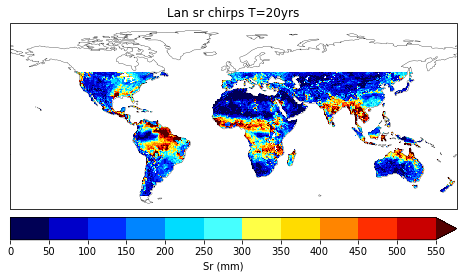

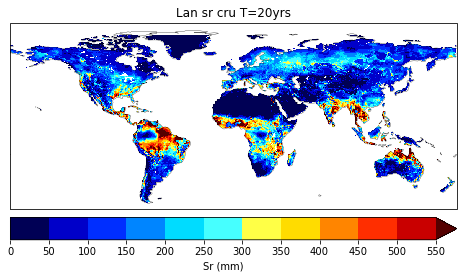

In [81]:
l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_chirps_20yrs.nc')
l = l.sr_chirps_20yrs[0]

lvls = np.arange(0,600,50) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = l.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'Lan sr chirps T=20yrs')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_chirps_20yrs.jpg',bbox_inches='tight',dpi=300)

l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_cru_20yrs.nc')
l = l.sr_cru_20yrs[0]

lvls = np.arange(0,600,50) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = l.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'Lan sr cru T=20yrs')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_cru_20yrs.jpg',bbox_inches='tight',dpi=300)


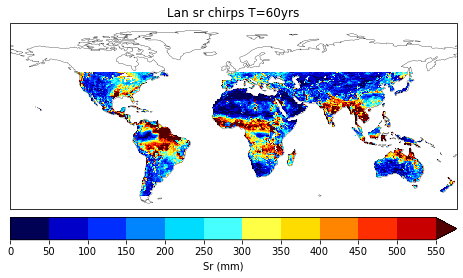

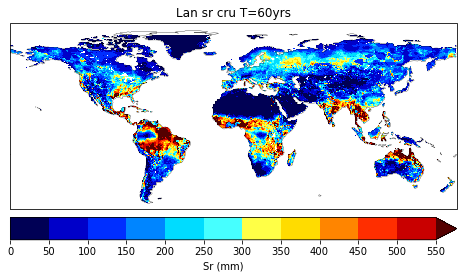

In [82]:
l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_chirps_60yrs.nc')
l = l.sr_chirps_60yrs[0]

lvls = np.arange(0,600,50) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = l.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'Lan sr chirps T=60yrs')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_chirps_60yrs.jpg',bbox_inches='tight',dpi=300)


l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_cru_60yrs.nc')
l = l.sr_cru_60yrs[0]

lvls = np.arange(0,600,50) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = l.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'Lan sr cru T=60yrs')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_cru_60yrs.jpg',bbox_inches='tight',dpi=300)


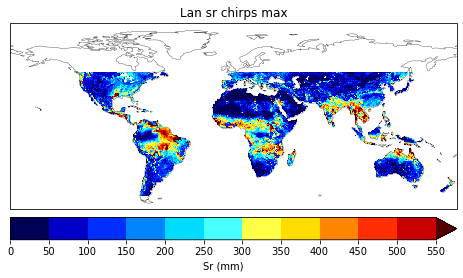

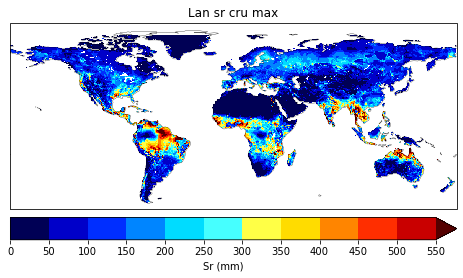

In [83]:
l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_chirps_max.nc')
l = l.sr_chirps_max[0]

lvls = np.arange(0,600,50) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = l.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'Lan sr chirps max')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_chirps_max.jpg',bbox_inches='tight',dpi=300)


l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_cru_max.nc')
l = l.sr_cru_max[0]

lvls = np.arange(0,600,50) # scale W-E paper
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = l.plot(ax=ax, cmap=cm, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'Lan sr cru max')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_cru_max.jpg',bbox_inches='tight',dpi=300)


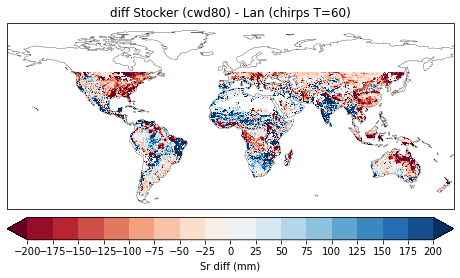

In [84]:
# diff lan-stocker
s = xr.open_dataset(f'{work_dir}/data/reference_sr/stocker/cwdx80_05grid.nc')
s = s.cwdx80

l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_chirps_60yrs.nc')
l = l.sr_chirps_60yrs[0]

d = s-l

lvls = np.linspace(-200,200,17) # scale W-E paper
cmapb = mpl.cm.RdBu
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = d.plot(ax=ax, cmap=cmapb, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr diff (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'diff Stocker (cwd80) - Lan (chirps T=60)')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_diff_lan_chirps_60yrs_stocker_cwd80.jpg',bbox_inches='tight',dpi=300)


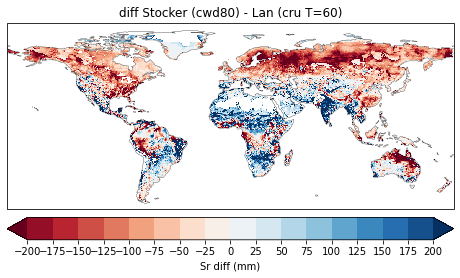

In [85]:
# diff lan-stocker
s = xr.open_dataset(f'{work_dir}/data/reference_sr/stocker/cwdx80_cru_grid.nc')
s = s.cwdx80

l = xr.open_dataset(f'{work_dir}/data/reference_sr/lan/sr_cru_60yrs.nc')
l = l.sr_cru_60yrs[0]

d = s-l

lvls = np.linspace(-200,200,17) # scale W-E paper
cmapb = mpl.cm.RdBu
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
cf = d.plot(ax=ax, cmap=cmapb, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label='Sr diff (mm)', pad=0.02, ticks = lvls)
ax.set_title(f'diff Stocker (cwd80) - Lan (cru T=60)')
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_diff_lan_cru_60yrs_stocker_cwd80.jpg',bbox_inches='tight',dpi=300)


### COMPARE LAN STOCKER TO MY SR ESTIMATES

In [5]:
#shapes
sh = gpd.read_file(f'{work_dir}/output/geo_catchments_sel_area_wb.shp')
sh.index = sh.catch_id
sh['centroid'] = sh.centroid

# sr dataframe
sr_df = pd.read_csv(f'{work_dir}/output/sr_calculation/sr_all_catchments.csv',index_col=0)
sr_df = sr_df[sr_df['20']>20]
# why are these shapes missing???
sr_df = sr_df.drop(['ar_0000023','br_0000133', 'br_0000116', 'br_0000146', 'br_0000168', 'br_0000247', 'br_0000264', 'br_0000129', 'pa_0000001', 'om_0000006', 'br_0000132', 'br_0000117', 'om_0000005', 'br_0000121', 'om_0000001', 'br_0000088', 'br_0000101', 'br_0000139', 'om_0000002', 'br_0000049', 'br_0000118', 'br_0000167', 'br_0000025', 'br_0000093', 'br_0000126', 'om_0000004', 'br_0000145', 'br_0000166', 'br_0000102', 'br_0000270', 'om_0000007', 'br_0000135', 'br_0000058', 'om_0000008', 'br_0000128'])
sr_df['lon'] = sh.centroid.x
sr_df['lat'] = sh.centroid.y

# # match sh and sr dfs
# sh_sr = sh.loc[sr_df.index]
# sh_sr['sr_60'] = sr_df['60']
# sh_sr = sh_sr.drop(columns=['geometry'])
# sh_sr = sh_sr.rename(columns={'centroid':'geometry'})

/tmp/ipykernel_1120893/420057374.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sh['centroid'] = sh.centroid
/tmp/ipykernel_1120893/420057374.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sr_df['lon'] = sh.centroid.x
/tmp/ipykernel_1120893/420057374.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sr_df['lat'] = sh.centroid.y


In [6]:
sr_df

2           3           5          10          20  \
catch_id                                                                 
za_0000167   42.244676   50.123918   58.899695   69.926766   80.504197   
es_0000787   97.760901  114.213299  132.537722  155.563004  177.649407   
br_0001831  197.573212  210.361952  224.605851  242.503811  259.671963   
es_0001076  110.477887  123.282567  137.544219  155.464486  172.654037   
de_0000289   82.748802   96.373033  111.547487  130.614722  148.904473   
...                ...         ...         ...         ...         ...   
us_0006131   62.902891   73.811168   85.960635  101.226868  115.870605   
fr_0000086  141.360921  167.350715  196.297740  232.670694  267.560506   
ca_0001025   37.108319   43.905170   51.475397   60.987653   70.112037   
br_0001145  183.899455  232.076974  285.736338  353.161216  417.836777   
138113A      94.163918  114.489862  137.128579  165.574924  192.861340   

                    30          40          50          60          70  \
catch_id                                                                 
za_0000167   86.589133   90.879200   94.195597   96.899572   99.182445   
es_0000787  190.355170  199.313125  206.237990  211.884076  216.650870   
br_0001831  269.548378  276.511555  281.894376  286.283178  289.988491   
es_0001076  182.542761  189.514617  194.904147  199.298419  203.008351   
de_0000289  159.426115  166.844197  172.578678  177.254201  181.201583   
...                ...         ...         ...         ...         ...   
us_0006131  124.294786  130.234093  134.825421  138.568891  141.729373   
fr_0000086  287.631753  301.782603  312.721787  321.640888  329.170975   
ca_0001025   75.361070   79.061801   81.922617   84.255140   86.224408   
br_0001145  455.043032  481.274592  501.552658  518.086076  532.044667   
138113A     208.558542  219.625555  228.180807  235.156205  241.045291   

                    80         lon        lat  
catch_id                                       
za_0000167  101.157875   29.617262 -29.576796  
es_0000787  220.775704   -1.672939  38.015789  
br_0001831  293.194798  -48.904344 -17.329335  
es_0001076  206.218654   -2.191177  42.054044  
de_0000289  184.617358    8.338023  47.837885  
...                ...         ...        ...  
us_0006131  144.464222  -96.932324  32.282105  
fr_0000086  335.686961    5.143091  44.592961  
ca_0001025   87.928469  -78.211763  45.539664  
br_0001145  544.123410  -38.728620 -12.041363  
138113A     246.141274  152.508856 -26.431179  

[4708 rows x 13 columns]

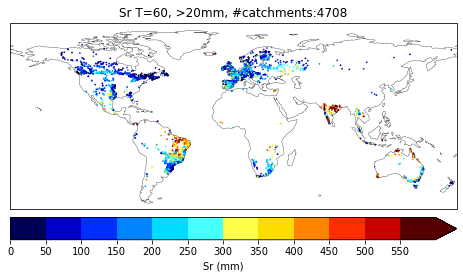

In [7]:
lvls = np.arange(0,600,50) # scale W-E paper
fig = plt.figure(figsize=(8,8))
# cm = plt.cm.get_cmap('jet')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=sr_df['60'],s=0.5,cmap=cm,vmin=0,vmax=600)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',extend='max', pad=0.02, ticks = lvls)
ax.set_title(f'Sr T=60, >20mm, #catchments:{len(sr_df)}',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_catchments_t60.jpg',bbox_inches='tight',dpi=300)


In [89]:
ls = pd.read_csv(f'{work_dir}/output/sr_calculation/stocker_lan_sr_df.csv',index_col=0)
ls = ls.loc[sr_df.index]

In [90]:
ls

stocker_cwd80x_mm  stocker_zroot_cwd80x_mm  lan_chirps_2yrs  \
catch_id                                                                  
za_0000167          109.63180                2198.7830        67.560560   
es_0000787          267.82960                5759.0107        34.439000   
br_0001831          337.44730                7400.7544       208.443480   
es_0001076          146.94089                2744.5740        78.863686   
de_0000289           73.67347                1160.4396        47.799854   
...                       ...                      ...              ...   
us_0006131          203.16913                5089.0180       181.369310   
fr_0000086          192.02019                3557.0957       178.940000   
ca_0001025          138.70978                2073.0930       135.965100   
br_0001145          763.12134               14588.0230       247.082210   
138113A             586.96936               12449.1880       372.520000   

            lan_chirps_5yrs  lan_chirps_10yrs  lan_chirps_20yrs  \
catch_id                                                          
za_0000167        81.658320          90.99440          99.94240   
es_0000787        45.880000          53.45600          60.72200   
br_0001831       239.063830         259.34460         278.79263   
es_0001076       102.800900         118.64705         133.84613   
de_0000289        66.195435          78.37523          90.05785   
...                     ...               ...               ...   
us_0006131       222.176390         249.19130         275.10190   
fr_0000086       208.390000         227.89000         246.59000   
ca_0001025       195.721510         235.28207         273.23264   
br_0001145       341.368700         403.78970         463.67065   
138113A          607.830000         763.63000         913.08000   

            lan_chirps_30yrs  lan_chirps_40yrs  lan_chirps_50yrs  \
catch_id                                                           
za_0000167         105.09569         108.73158         111.53744   
es_0000787          64.90200          67.84900          70.12700   
br_0001831         289.97775         297.86786         303.96680   
es_0001076         142.59177         148.75720         153.52255   
de_0000289          96.77667         101.52010         105.18323   
...                      ...               ...               ...   
us_0006131         290.01367         300.52417         308.64548   
fr_0000086         257.35000         264.94000         270.80000   
ca_0001025         295.06406         310.45870         322.35553   
br_0001145         498.11620         522.40660         541.18190   
138113A            999.05000        1059.70000        1106.50000   

            lan_chirps_60yrs  lan_chirps_max  lan_cru_2yrs  lan_cru_5yrs  \
catch_id                                                                   
za_0000167        113.822876        87.90170     63.029022     89.089300   
es_0000787         71.985000        56.92500     75.710000     91.447000   
br_0001831        308.940200       257.83527    169.731610    217.700440   
es_0001076        157.407820       106.80363     64.112114     85.255140   
de_0000289        108.165510        79.43423     42.265724     62.192245   
...                      ...             ...           ...           ...   
us_0006131        315.268900       235.80081    165.535700    212.461700   
fr_0000086        275.580000       221.86000     94.613000    129.750000   
ca_0001025        332.057920       217.71147     91.305670    143.910300   
br_0001145        556.487100       380.20804    261.989350    428.752300   
138113A          1144.700000       795.54000    102.430000    122.260000   

            lan_cru_10yrs  lan_cru_20yrs  lan_cru_30yrs  lan_cru_40yrs  \
catch_id                                                                 
za_0000167     106.342964     122.898080     132.416050     139.128880   
es_0000787     101.870000     111.860000     117.610000     121.6700

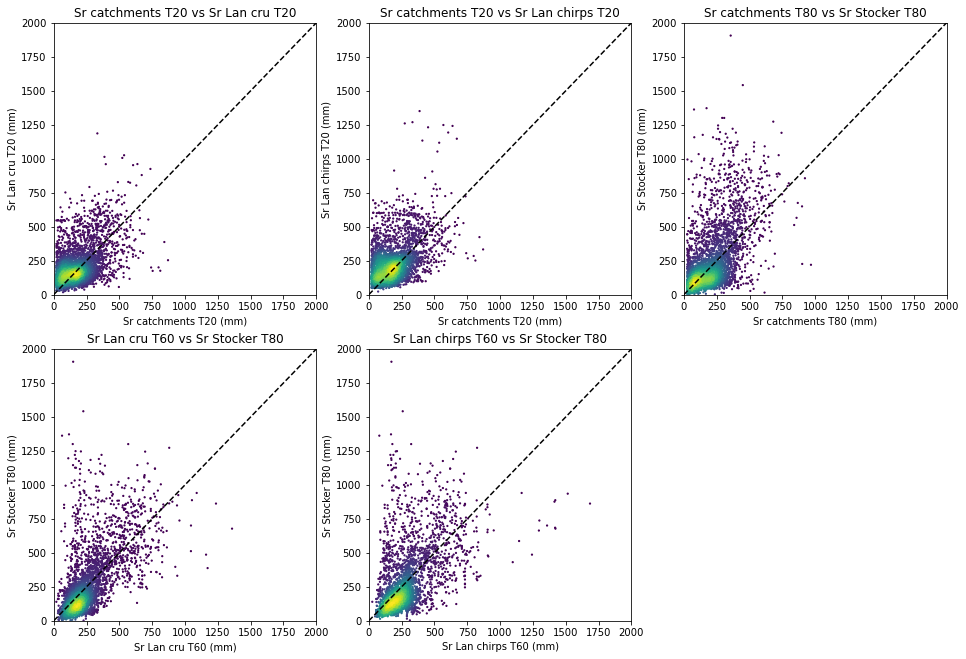

In [104]:
fig = plt.figure(figsize=(16,11))
ax = fig.add_subplot(231)
x = sr_df['20']
y = ls['lan_cru_20yrs']
y =  y.dropna()
x = x[y.index]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.scatter(x,y,c=z,s=1.5)
ax.plot([0,2000],[0,2000],'k--')
ax.set_xlim(0,2000)
ax.set_ylim(0,2000)
ax.set_xlabel('Sr catchments T20 (mm)')
ax.set_ylabel('Sr Lan cru T20 (mm)')
ax.set_title('Sr catchments T20 vs Sr Lan cru T20')

ax = fig.add_subplot(232)
x = sr_df['20']
y = ls['lan_chirps_20yrs']
y =  y.dropna()
x = x[y.index]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.scatter(x,y,c=z,s=1.5)
ax.plot([0,2000],[0,2000],'k--')
ax.set_xlim(0,2000)
ax.set_ylim(0,2000)
ax.set_xlabel('Sr catchments T20 (mm)')
ax.set_ylabel('Sr Lan chirps T20 (mm)')
ax.set_title('Sr catchments T20 vs Sr Lan chirps T20')

ax = fig.add_subplot(233)
x = sr_df['80']
y = ls['stocker_cwd80x_mm']
x = x.dropna()
y = y[x.index]
y =  y.dropna()
x = x[y.index]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.scatter(x,y,c=z,s=1.5)
ax.plot([0,2000],[0,2000],'k--')
ax.set_xlim(0,2000)
ax.set_ylim(0,2000)
ax.set_xlabel('Sr catchments T80 (mm)')
ax.set_ylabel('Sr Stocker T80 (mm)')
ax.set_title('Sr catchments T80 vs Sr Stocker T80')

ax = fig.add_subplot(234)
x = ls['lan_cru_60yrs']
y = ls['stocker_cwd80x_mm']
x = x.dropna()
y = y[x.index]
y =  y.dropna()
x = x[y.index]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.scatter(x,y,c=z,s=1.5)
ax.plot([0,2000],[0,2000],'k--')
ax.set_xlim(0,2000)
ax.set_ylim(0,2000)
ax.set_xlabel('Sr Lan cru T60 (mm)')
ax.set_ylabel('Sr Stocker T80 (mm)')
ax.set_title('Sr Lan cru T60 vs Sr Stocker T80')

ax = fig.add_subplot(235)
x = ls['lan_chirps_60yrs']
y = ls['stocker_cwd80x_mm']
x = x.dropna()
y = y[x.index]
y =  y.dropna()
x = x[y.index]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax.scatter(x,y,c=z,s=1.5)
ax.plot([0,2000],[0,2000],'k--')
ax.set_xlim(0,2000)
ax.set_ylim(0,2000)
ax.set_xlabel('Sr Lan chirps T60 (mm)')
ax.set_ylabel('Sr Stocker T80 (mm)')
ax.set_title('Sr Lan chirps T60 vs Sr Stocker T80')
fig.savefig(f'{out_dir}/figures/sr_figures/sr_catchments_vs_reference',bbox_inches='tight',dpi=300)


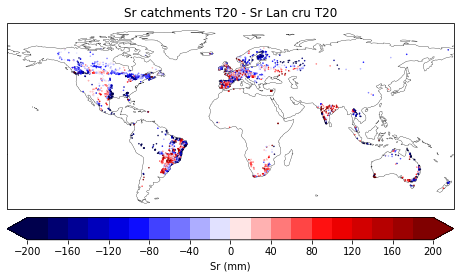

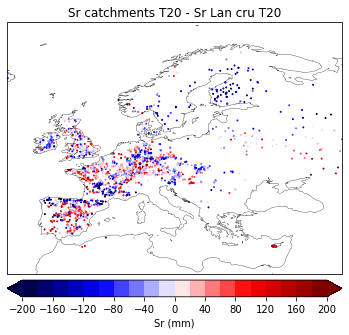

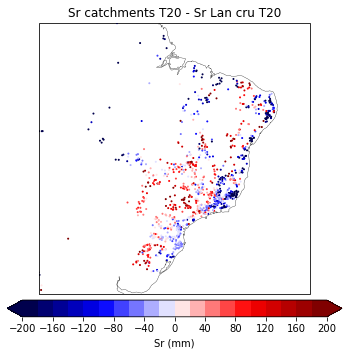

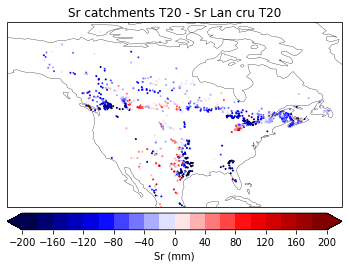

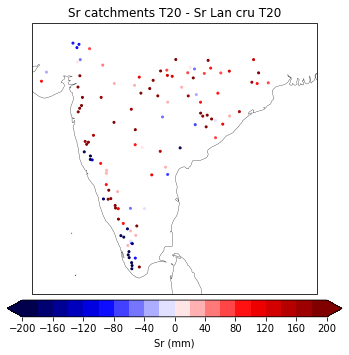

In [114]:
# catchments vs Lan cru T20

cmap = plt.cm.seismic  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cm2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(-200,200,21)
bounds2 = np.linspace(-200,200,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

dif = sr_df['20']-ls['lan_cru_20yrs']
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=0.3,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr catchments T20 - Sr Lan cru T20',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_catchments_vs_sr_lan_cru_T20.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-15,45)
ax.set_ylim(30,75)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr catchments T20 - Sr Lan cru T20',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_catchments_vs_sr_lan_cru_T20_europe.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-70,-30)
ax.set_ylim(-35,5)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr catchments T20 - Sr Lan cru T20',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_catchments_vs_sr_lan_cru_T20_brazil.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-150,-50)
ax.set_ylim(20,75)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr catchments T20 - Sr Lan cru T20',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_catchments_vs_sr_lan_cru_T20_na.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(70,90)
ax.set_ylim(7,26)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=4,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr catchments T20 - Sr Lan cru T20',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_catchments_vs_sr_lan_cru_T20_india.jpg',bbox_inches='tight',dpi=300)


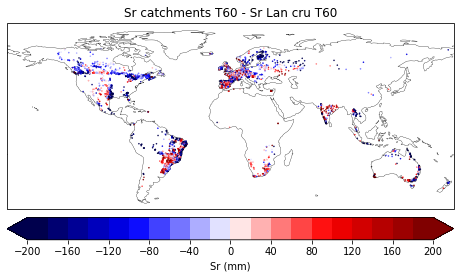

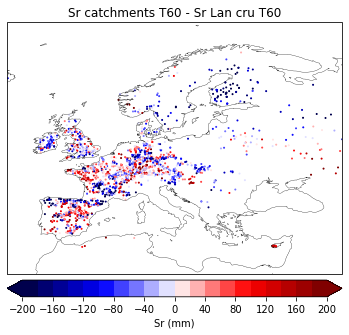

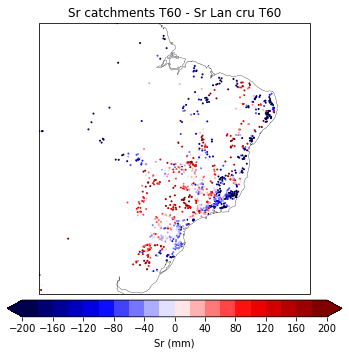

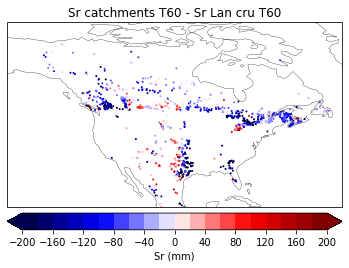

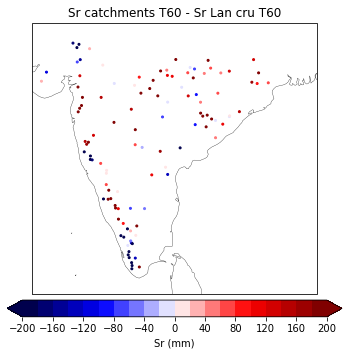

In [120]:
# catchments vs Lan cru T60

cmap = plt.cm.seismic  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cm2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(-200,200,21)
bounds2 = np.linspace(-200,200,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

dif = sr_df['60']-ls['lan_cru_60yrs']
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=0.3,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr catchments T60 - Sr Lan cru T60',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_catchments_vs_sr_lan_cru_T60.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-15,45)
ax.set_ylim(30,75)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr catchments T60 - Sr Lan cru T60',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_catchments_vs_sr_lan_cru_T60_europe.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-70,-30)
ax.set_ylim(-35,5)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr catchments T60 - Sr Lan cru T60',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_catchments_vs_sr_lan_cru_T60_brazil.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-150,-50)
ax.set_ylim(20,75)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr catchments T60 - Sr Lan cru T60',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_catchments_vs_sr_lan_cru_T60_na.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(70,90)
ax.set_ylim(7,26)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=4,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr catchments T60 - Sr Lan cru T60',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_catchments_vs_sr_lan_cru_T60_india.jpg',bbox_inches='tight',dpi=300)

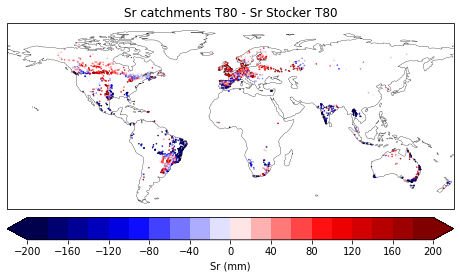

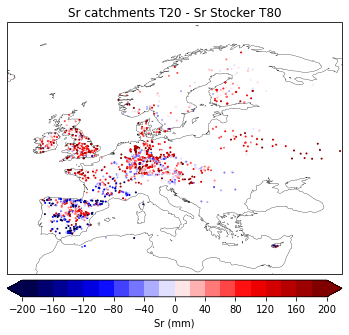

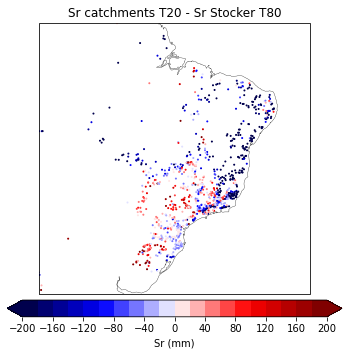

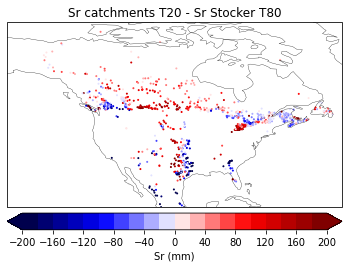

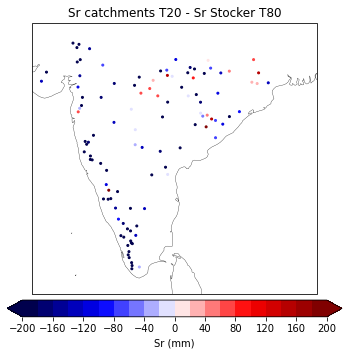

In [117]:
# catchments vs Stocker T80

cmap = plt.cm.seismic  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cm2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(-200,200,21)
bounds2 = np.linspace(-200,200,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

dif = sr_df['80']-ls['stocker_cwd80x_mm']
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=0.3,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr catchments T80 - Sr Stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_catchments_vs_sr_stocker_T80.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-15,45)
ax.set_ylim(30,75)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr catchments T20 - Sr Stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_catchments_vs_sr_stocker_T80_europe.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-70,-30)
ax.set_ylim(-35,5)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr catchments T20 - Sr Stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_catchments_vs_sr_stocker_T80_brazil.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-150,-50)
ax.set_ylim(20,75)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr catchments T20 - Sr Stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_catchments_vs_sr_stocker_T80_na.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(70,90)
ax.set_ylim(7,26)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=4,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'Sr catchments T20 - Sr Stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_catchments_vs_sr_stocker_T80_india.jpg',bbox_inches='tight',dpi=300)

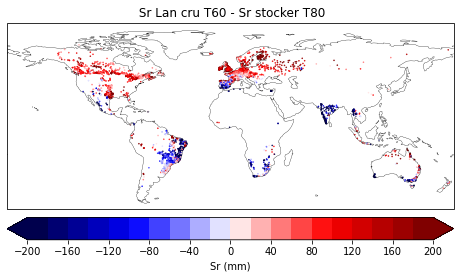

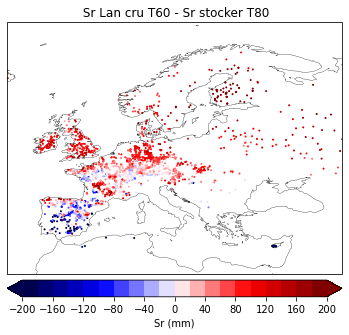

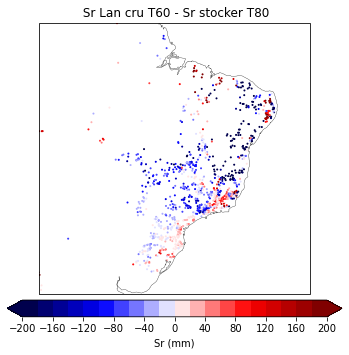

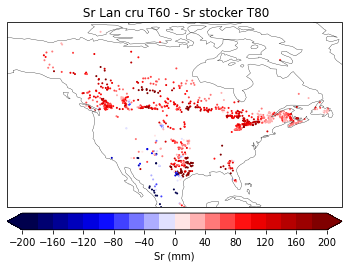

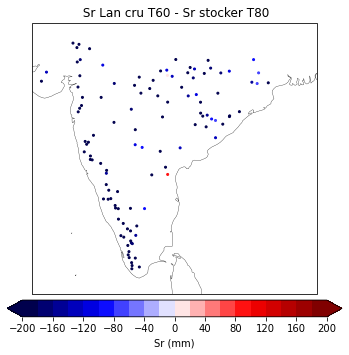

In [118]:
# Lan T60 vs Stocker T80

cmap = plt.cm.seismic  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cm2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(-200,200,21)
bounds2 = np.linspace(-200,200,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

dif = ls['lan_cru_60yrs'] - ls['stocker_cwd80x_mm']
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=0.3,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f' Sr Lan cru T60 - Sr stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_cru_T60_vs_sr_stocker_T80.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-15,45)
ax.set_ylim(30,75)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f' Sr Lan cru T60 - Sr stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_cru_T60_vs_sr_stocker_T80_europe.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-70,-30)
ax.set_ylim(-35,5)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f' Sr Lan cru T60 - Sr stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_cru_T60_vs_sr_stocker_T80_brazil.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-150,-50)
ax.set_ylim(20,75)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f' Sr Lan cru T60 - Sr stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_cru_T60_vs_sr_stocker_T80_na.jpg',bbox_inches='tight',dpi=300)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(70,90)
ax.set_ylim(7,26)
s = ax.scatter(sr_df.lon,sr_df.lat,c=dif,s=4,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='Sr (mm)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f' Sr Lan cru T60 - Sr stocker T80',size=12)
fig.savefig(f'{out_dir}/figures/sr_figures/sr_lan_cru_T60_vs_sr_stocker_T80_india.jpg',bbox_inches='tight',dpi=300)

## compare gswp3 vs cru P mean

In [ ]:
cb = pd.read_csv(f"{work_dir}/output/forcing_timeseries/cru_p/mean_p.csv",index_col=0)

In [76]:
# merge cru mean values in dataframe - area weighted
files = glob.glob(f"{work_dir}/output/forcing_timeseries/processed/mean/*")[:]
li=[] #empty list
for filename in files:
    df = pd.read_csv(filename, index_col=0) #read file as dataframe
    f1 = filename.split('mean/')[1]
    f2 = f1.split('_1981')[0]
    d = pd.DataFrame(index=[f2],columns=['gswp_mean_p_aw','gswp_mean_tas_aw','gleam_mean_ep_aw'])
    d['gswp_mean_p_aw'] = df.loc['p'].values
    d['gswp_mean_tas_aw'] = df.loc['tas'].values
    d['gleam_mean_ep_aw'] = df.loc['ep'].values
    li.append(d) #append file to list
g = pd.concat(li, axis=0) #concatenate lists
g.to_csv(f"{work_dir}/output/forcing_timeseries/mean_gswp_p_tas_gleam_ep.csv")

In [77]:
g

gswp_mean_p_aw  gswp_mean_tas_aw  gleam_mean_ep_aw
us_0006103        2.702065         18.467334          2.336372
us_0000494        3.525299         11.380863          2.182724
de_0000034        2.474530          8.290679          1.399034
br_0003176        4.607076         18.368823          2.767885
es_0000546        1.340153         15.185329          2.075936
...                    ...               ...               ...
gb_0000003        5.582428          6.756923          1.365660
us_0003034        3.920179         13.990498          2.443044
fr_0000088        2.982091          8.880337          2.153611
us_0005996        4.525385         19.698371          2.836077
br_0000103        5.267339         26.132254          4.236695

[8658 rows x 3 columns]

In [111]:
df = pd.concat([g,cb],axis=1)
df['dif']=df['gswp_mean_p_aw']-df['cru_mean_p_aw']
df['reldif'] = ((df['gswp_mean_p_aw']-df['cru_mean_p_aw'])/df['gswp_mean_p_aw']) 

#shapes
sh = gpd.read_file(f'{work_dir}/output/geo_catchments_sel_area_wb.shp')
sh.index = sh.catch_id
sh['centroid'] = sh.centroid

# sr dataframe
df['lon'] = sh.centroid.x
df['lat'] = sh.centroid.y

/tmp/ipykernel_3270075/2382259158.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sh['centroid'] = sh.centroid
/tmp/ipykernel_3270075/2382259158.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['lon'] = sh.centroid.x
/tmp/ipykernel_3270075/2382259158.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['lat'] = sh.centroid.y


Text(0.5, 1.0, 'rel diff (gswp3 - cru mean P) /gswp3')

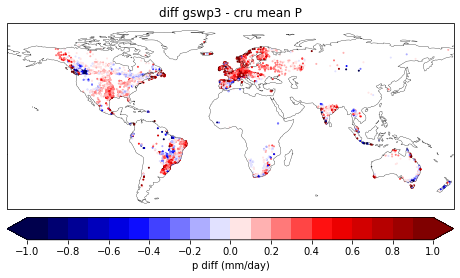

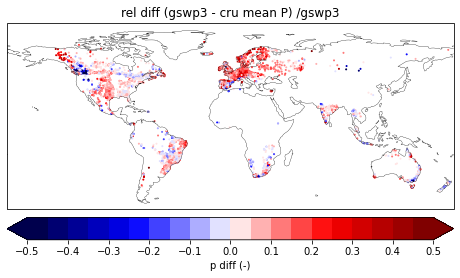

In [112]:
cmap = plt.cm.seismic  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cm2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(-1,1,21)
bounds2 = np.linspace(-1,1,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(df.lon,df.lat,c=df['dif'],s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='p diff (mm/day)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'diff gswp3 - cru mean P',size=12)

cmap = plt.cm.seismic  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cm2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(-0.5,0.5,21)
bounds2 = np.linspace(-0.5,0.5,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(df.lon,df.lat,c=df['reldif'],s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='p diff (-)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'rel diff (gswp3 - cru mean P) /gswp3',size=12)


### compare elevation - mean

Text(0, 0.5, 'mean elevation EE')

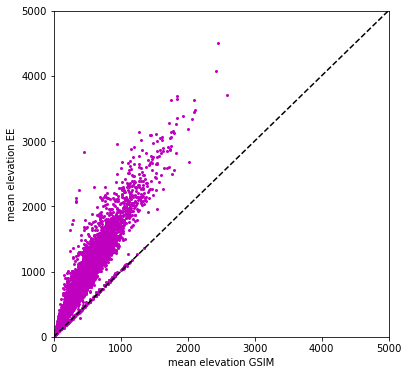

In [9]:
cc = pd.read_csv(f'{work_dir}/output/catchment_characteristics.csv',index_col=0)
elg = cc.el_mean

el = pd.read_csv(f'{work_dir}/output/elevation/all_catchment_elevation_stats_hydrosheds.csv',index_col=0)
ele = el.mean_ele

df = pd.DataFrame(index=elg.index,columns=['elg','ele'])
df['elg']=elg
df['ele']=ele
df['dif']=df['ele']-df['elg']
df['reldif']=df['dif']/df['ele']

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(df.elg,df.ele,'mo',markersize=2)
ax.plot([0,5000],[0,5000],'k--')
ax.set_xlim(0,5000)
ax.set_ylim(0,5000)
ax.set_xlabel('mean elevation GSIM')
ax.set_ylabel('mean elevation EE')

In [6]:
#shapes
sh = gpd.read_file(f'{work_dir}/output/geo_catchments_sel_area_wb.shp')
sh.index = sh.catch_id
sh['centroid'] = sh.centroid

# sr dataframe
df['lon'] = sh.centroid.x
df['lat'] = sh.centroid.y

/tmp/ipykernel_2949307/1714722488.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sh['centroid'] = sh.centroid
/tmp/ipykernel_2949307/1714722488.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['lon'] = sh.centroid.x
/tmp/ipykernel_2949307/1714722488.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['lat'] = sh.centroid.y


Text(0.5, 1.0, 'diff elevation earth engine-gsim / earth engine')

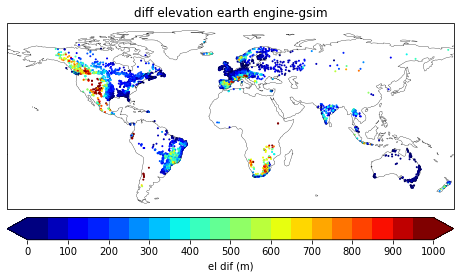

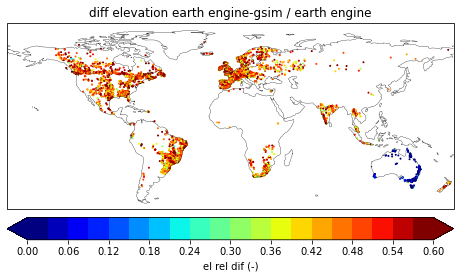

In [7]:
cmap = plt.cm.jet  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cm2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0,1000,21)
bounds2 = np.linspace(0,1000,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(df.lon,df.lat,c=df['dif'],s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='el dif (m)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'diff elevation earth engine-gsim',size=12)

cmap = plt.cm.jet  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cm2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0,0.6,21)
bounds2 = np.linspace(0,0.6,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(df.lon,df.lat,c=df['reldif'],s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='el rel dif (-)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'diff elevation earth engine-gsim / earth engine',size=12)

### compare elevation - max

Text(0, 0.5, 'max elevation EE')

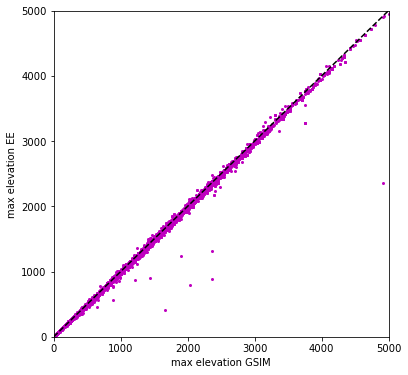

In [12]:
cc = pd.read_csv(f'{work_dir}/output/catchment_characteristics.csv',index_col=0)
elg = cc.el_max

el = pd.read_csv(f'{work_dir}/output/elevation/all_catchment_elevation_stats_hydrosheds.csv',index_col=0)
ele = el.max_ele

df = pd.DataFrame(index=elg.index,columns=['elg','ele'])
df['elg']=elg
df['ele']=ele
df['dif']=df['ele']-df['elg']
df['reldif']=df['dif']/df['ele']

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(df.elg,df.ele,'mo',markersize=2)
ax.plot([0,5000],[0,5000],'k--')
ax.set_xlim(0,5000)
ax.set_ylim(0,5000)
ax.set_xlabel('max elevation GSIM')
ax.set_ylabel('max elevation EE')

In [13]:
#shapes
sh = gpd.read_file(f'{work_dir}/output/geo_catchments_sel_area_wb.shp')
sh.index = sh.catch_id
sh['centroid'] = sh.centroid

# sr dataframe
df['lon'] = sh.centroid.x
df['lat'] = sh.centroid.y

/tmp/ipykernel_2949307/1714722488.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sh['centroid'] = sh.centroid
/tmp/ipykernel_2949307/1714722488.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['lon'] = sh.centroid.x
/tmp/ipykernel_2949307/1714722488.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['lat'] = sh.centroid.y


Text(0.5, 1.0, 'diff elevation earth engine-gsim / earth engine')

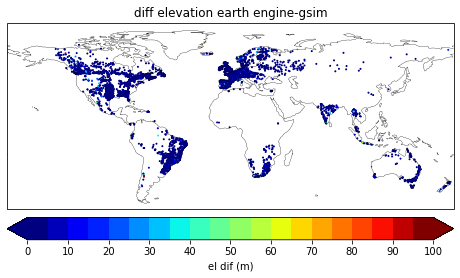

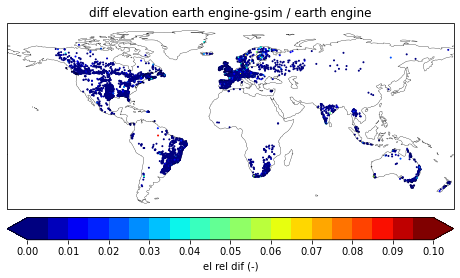

In [15]:
cmap = plt.cm.jet  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cm2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0,100,21)
bounds2 = np.linspace(0,100,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(df.lon,df.lat,c=df['dif'],s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='el dif (m)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'diff elevation earth engine-gsim',size=12)

cmap = plt.cm.jet  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cm2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0,0.1,21)
bounds2 = np.linspace(0,0.1,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(df.lon,df.lat,c=df['reldif'],s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='el rel dif (-)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'diff elevation earth engine-gsim / earth engine',size=12)

Text(0, 0.5, 'mean slope EE')

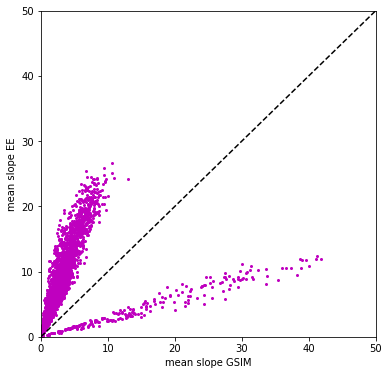

In [8]:
cc = pd.read_csv(f'{work_dir}/output/catchment_characteristics.csv',index_col=0)
elg = cc.slp_mean

el = pd.read_csv(f'{work_dir}/output/elevation/all_catchment_slope_stats_hydrosheds.csv',index_col=0)
ele = el.mean_slope

df = pd.DataFrame(index=elg.index,columns=['elg','ele'])
df['elg']=elg
df['ele']=ele
df['dif']=df['ele']-df['elg']
df['reldif']=df['dif']/df['ele']

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(df.elg,df.ele,'mo',markersize=2)
ax.plot([0,50],[0,50],'k--')
ax.set_xlim(0,50)
ax.set_ylim(0,50)
ax.set_xlabel('mean slope GSIM')
ax.set_ylabel('mean slope EE')

Text(0, 0.5, 'mean slope EE')

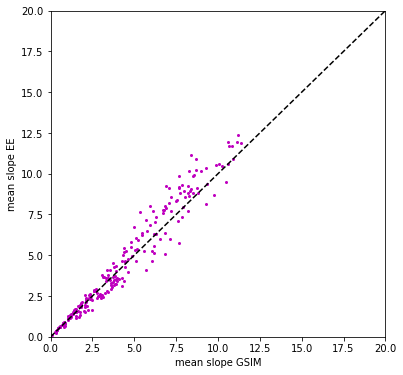

In [28]:
cc = pd.read_csv(f'{work_dir}/output/catchment_characteristics.csv',index_col=0)
elg = cc.slp_mean

el = pd.read_csv(f'{work_dir}/output/elevation/all_catchment_slope_stats_hydrosheds.csv',index_col=0)
ele = el.mean_slope

df = pd.DataFrame(index=elg.index,columns=['elg','ele'])
df['elg']=elg
df['ele']=ele
df['dif']=df['ele']-df['elg']
df['reldif']=df['dif']/df['ele']

df = df[df['dif']<0]
df['elg_deg'] = np.arctan(df['elg']/100) * (180/np.pi) /2

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.plot(df.elg_deg,df.ele,'mo',markersize=2)
ax.plot([0,50],[0,50],'k--')
ax.set_xlim(0,20)
ax.set_ylim(0,20)
ax.set_xlabel('mean slope GSIM')
ax.set_ylabel('mean slope EE')

In [27]:
df

elg        ele        dif    reldif    elg_deg
226407    24.38   5.103577 -19.276423 -3.777042  13.701421
136203A   13.97   3.576507 -10.393493 -2.906046   7.952751
222213    25.25   8.199574 -17.050426 -2.079428  14.170978
138004B   12.88   3.049106  -9.830894 -3.224188   7.339289
406214     6.06   1.975168  -4.084832 -2.068093   3.467883
...         ...        ...        ...       ...        ...
122004A   29.43   8.842045 -20.587955 -2.328416  16.399156
401217    33.55  10.356440 -23.193560 -2.239530  18.546603
105102A   14.47   3.530434 -10.939566 -3.098647   8.233552
A2390531   1.05   0.262888  -0.787112 -2.994089   0.601584
138113A   21.98   5.143353 -16.836647 -3.273476  12.396488

[222 rows x 5 columns]

/tmp/ipykernel_2949307/1162412739.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sh['centroid'] = sh.centroid
/tmp/ipykernel_2949307/1162412739.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['lon'] = sh.centroid.x
/tmp/ipykernel_2949307/1162412739.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['lat'] = sh.centroid.y


Text(0.5, 1.0, 'diff slope earth engine-gsim / earth engine')

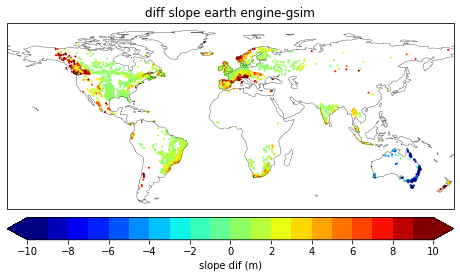

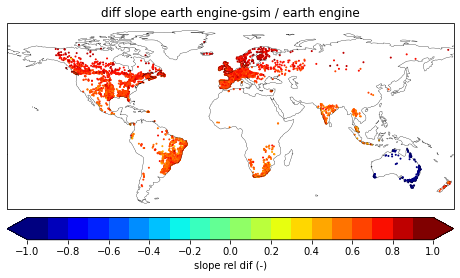

In [31]:
#shapes
sh = gpd.read_file(f'{work_dir}/output/geo_catchments_sel_area_wb.shp')
sh.index = sh.catch_id
sh['centroid'] = sh.centroid

# sr dataframe
df['lon'] = sh.centroid.x
df['lat'] = sh.centroid.y

cmap = plt.cm.jet  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cm2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(-10,10,21)
bounds2 = np.linspace(-10,10,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(df.lon,df.lat,c=df['dif'],s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='slope dif (m)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'diff slope earth engine-gsim',size=12)

cmap = plt.cm.jet  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cm2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(-1,1,21)
bounds2 = np.linspace(-1,1,11)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.3)
ax.set_xlim(-180,180)
ax.set_ylim(-60,90)
s = ax.scatter(df.lon,df.lat,c=df['reldif'],s=1,cmap=cm2, norm=norm)
cbar = plt.colorbar(s, orientation='horizontal', label='slope rel dif (-)',spacing='proportional',extend='both', pad=0.02, norm=norm,ticks=bounds2)
ax.set_title(f'diff slope earth engine-gsim / earth engine',size=12)

In [30]:
df['reldif'].mean()

0.5882855012966464